# Setup Environment

## Load Python Modules

In [75]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_fscore_support
# import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import os
from data_loader import *
import util
from MLP import *
from copy import deepcopy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Show NVIDIA GPU

In [53]:
!nvidia-smi -L

GPU 0: NVIDIA H200 (UUID: GPU-a834fce4-9456-6c32-43bc-8d8574de0b1f)


## Setup utility

In [54]:
util.setup_logger()

# Load and Process Dataset

## Load Dataset (Embedded split, workaround)

In [55]:
folder_path = "/mnt/dataset"
_all_dataset = data_loader(os.path.join(folder_path, "feature"), os.path.join(folder_path, "label"))
_files = _all_dataset.file_names
train_files, valid_files = train_test_split(_files, test_size=.2)
valid_files, test_files = train_test_split(valid_files, test_size=.5)
train_dataset = deepcopy(_all_dataset)
train_dataset.file_names = train_files
train_dataset.downsample_size = (64, 64)
valid_dataset = deepcopy(_all_dataset)
valid_dataset.file_names = valid_files
valid_dataset.downsample_size = (64, 64)
test_dataset = deepcopy(_all_dataset)
test_dataset.file_names = test_files

logging.info(f"{len(train_dataset)} images for train, {len(valid_dataset)} for validation, and {len(test_dataset)} for testing")

[INFO] 8193 images for train, 1024 for validation, and 1025 for testing


## Load Dataset (Hard split, ideal but not ready)

In [8]:
# folder_path = os.path.join(os.getenv("HOME"), "scratch")
folder_path = "/mnt/dataset"
valid_dir = "./dataset/validation"
train_dataset = data_loader(os.path.join(folder_path, "feature"), os.path.join(folder_path, "label"))
valid_dataset = data_loader(os.path.join(valid_dir, "feature"), os.path.join(valid_dir, "label"))
# test_dataset  = ImageDataset(os.path.join(folder_path, "test_10p.csv"), use_augmentation=False)

In [9]:
train_dataset.check()

# MLP Model

## Create Torch Data Loaders

In [56]:
# train_loader, valid_loader, test_loader = dataset.get_loaders()
train_loader = train_dataset.get_torch_loader()
valid_loader = valid_dataset.get_torch_loader()
test_loader  = test_dataset.get_torch_loader()

## Check CUDA Availability

In [57]:
# "cuda" only when GPUs are available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Debug

In [58]:
path = os.path.join("/mnt/dataset", "feature")
print("Is symlink:", os.path.islink(path))
print("Exists:", os.path.exists(path))
print("Real path:", os.path.realpath(path))

Is symlink: False
Exists: True
Real path: /mnt/dataset/feature


In [63]:
file_name = "10000-zero-riscy-b-3-c2-u0.85-m1-p6-f1.npy"
feature = np.load(os.path.join("/mnt/dataset", "feature", file_name)) 
label = np.load(os.path.join("/mnt/dataset", "label", file_name))     
feature = np.transpose(feature, (2, 0, 1)) 
label = np.transpose(label, (2, 0, 1)) 
feature_tensor = torch.from_numpy(feature).float()
label_tensor = torch.from_numpy(label).float() 
feature_tensor = feature_tensor.unsqueeze(0) 
label_tensor = label_tensor.unsqueeze(0)
target_size = (64, 64)
feature_ds = F.interpolate(feature_tensor, size=target_size, mode='bilinear', align_corners=False)
label_ds = F.interpolate(label_tensor, size=target_size, mode='bilinear', align_corners=False)
print("Feature downsampled shape:", feature_ds.shape)
print("Label downsampled shape:", label_ds.shape) 
model = MLP_FC(input_channels=24, target_size=64)
print(model)

Feature downsampled shape: torch.Size([1, 24, 64, 64])
Label downsampled shape: torch.Size([1, 1, 64, 64])
MLP_FC(
  (mlp): Sequential(
    (0): Linear(in_features=98304, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=4096, bias=True)
  )
)


In [67]:
for batch in train_loader:
    x, y = batch
    x = x.to(device)
    y = y.to(device)

    predict = model(x)  # (batch, 1, 64, 64)
    y_down = F.adaptive_avg_pool2d(y, (64, 64))  # (batch, 1, 64, 64)

    loss = criterion(predict, y_down)
    print("Loss:", loss.item())
    break  # just one batch for test
criterion = nn.MSELoss()
model = model.to(device)
predict = model(x.to(device))
loss = criterion(predict, y_down.to(device))

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Loss: 0.14765122532844543
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


## Training Setup

In [68]:
_exp_name = "MLP_0702"
# The number of training epochs and patience.
n_epochs = 100
patience = 30 # If no improvement in 'patience' epochs, early stop

# Initialize a model, and put it on the device specified.
model, train_losses, valid_losses = try_load_model(_exp_name)
if model == None:
    model = MLP_FC().to(device)

# For the classification task, we use cross-entropy as the measurement of performance.
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-5)

## Training

In [72]:
train_model(model, optimizer, train_loader, valid_loader, n_epochs=n_epochs, patience=patience,
            criterion=nn.MSELoss(), train_losses = train_losses, valid_losses = valid_losses,
            prefix = _exp_name)

  3%|▎         | 1/32 [00:02<01:25,  2.76s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:05<01:22,  2.76s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:08<01:22,  2.84s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:11<01:17,  2.77s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:14<01:17,  2.85s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:16<01:13,  2.83s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:19<01:10,  2.81s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:22<01:05,  2.73s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:25<01:04,  2.81s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:27<01:00,  2.77s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:30<00:57,  2.72s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:33<00:56,  2.81s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:36<00:54,  2.85s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:39<00:50,  2.78s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:41<00:46,  2.76s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:44<00:44,  2.76s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:47<00:40,  2.68s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:50<00:39,  2.80s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:52<00:36,  2.81s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:55<00:32,  2.71s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:57<00:28,  2.62s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [01:00<00:26,  2.68s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [01:03<00:24,  2.67s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [01:06<00:21,  2.69s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [01:08<00:18,  2.70s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [01:11<00:16,  2.77s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [01:14<00:14,  2.81s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [01:17<00:11,  2.81s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [01:20<00:08,  2.83s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [01:23<00:05,  2.80s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [01:25<00:02,  2.80s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [01:28<00:00,  2.75s/it]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 001/100 ] loss = 0.035567
[ Valid | 001/100 ] loss = 0.035567 -> best


  0%|          | 1/257 [00:00<00:39,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:40,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:00<00:40,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:01<00:39,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:39,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:38,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:01<00:38,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:38,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:02<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:03<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:03<00:37,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:36,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 23/257 [00:03<00:36,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|▉         | 25/257 [00:03<00:36,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:37,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:04<00:37,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:37,  6.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:04<00:37,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:04<00:36,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:05<00:35,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:05<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:05<00:34,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:06<00:34,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:33,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:06<00:33,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:06<00:32,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:32,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:07<00:33,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:07<00:32,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:32,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 49/257 [00:07<00:32,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:08<00:32,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:08<00:32,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:08<00:32,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:09<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:09<00:31,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:09<00:31,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:09<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [00:10<00:30,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:29,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [00:10<00:30,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 69/257 [00:10<00:29,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [00:11<00:29,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:28,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:11<00:28,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:11<00:28,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:12<00:28,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:12<00:27,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:13<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:13<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:13<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:14<00:26,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:25,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:14<00:25,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:15<00:25,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:15<00:25,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:15<00:24,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:15<00:24,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:23,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:16<00:23,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:23,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:16<00:23,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:16<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:17<00:23,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:17<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:17<00:22,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:17<00:22,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [00:18<00:21,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [00:18<00:21,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:18<00:21,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 121/257 [00:19<00:21,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 123/257 [00:19<00:21,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▊     | 125/257 [00:19<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 127/257 [00:20<00:20,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [00:20<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:19,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:20<00:19,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:20<00:19,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:21<00:19,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:21<00:18,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:21<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:22<00:18,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [00:22<00:17,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 145/257 [00:22<00:17,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [00:23<00:17,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:16,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:23<00:16,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:23<00:16,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:23<00:16,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:24<00:16,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:24<00:15,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:24<00:15,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:24<00:15,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:25<00:15,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [00:25<00:14,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:14,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 163/257 [00:25<00:14,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:25<00:14,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 165/257 [00:25<00:14,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [00:26<00:14,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [00:26<00:13,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [00:26<00:13,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [00:27<00:13,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:27<00:12,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [00:27<00:12,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [00:28<00:12,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [00:28<00:11,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [00:28<00:11,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:28<00:11,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:29<00:11,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:29<00:10,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [00:29<00:10,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:29<00:10,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:30<00:10,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:30<00:09,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:30<00:09,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:30<00:09,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:30<00:09,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:31<00:08,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:08,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:31<00:08,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:31<00:08,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:31<00:08,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:32<00:08,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:07,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:32<00:07,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:32<00:07,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:32<00:07,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:33<00:07,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:06,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:33<00:06,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:33<00:06,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:33<00:06,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:34<00:06,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:34<00:05,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:34<00:05,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:34<00:05,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:35<00:05,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:35<00:04,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:35<00:04,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:35<00:04,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:35<00:04,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:36<00:04,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:36<00:03,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:36<00:03,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:36<00:03,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:37<00:03,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:02,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:37<00:02,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:37<00:02,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:37<00:02,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:37<00:02,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:38<00:02,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:38<00:01,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:38<00:01,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:38<00:01,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:38<00:01,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:39<00:01,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:39<00:00,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:39<00:00,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:39<00:00,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:39<00:00,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.40it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 002/100 ] loss = 0.027223


  3%|▎         | 1/32 [00:00<00:04,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:01<00:02,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:01,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 002/100 ] loss = 0.026301
[ Valid | 002/100 ] loss = 0.026301 -> best
Epoch 2 duration: 44.95 seconds
Best model found at epoch 1, saving model



  1%|          | 2/257 [00:00<00:40,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:38,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:32,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:32,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:32,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:25,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:25,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:18,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:17,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:12,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:12,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:11,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:07,  6.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.08it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:04,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.28it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 003/100 ] loss = 0.023298


  6%|▋         | 2/32 [00:00<00:04,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:04,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:04<00:00,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.45it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 003/100 ] loss = 0.026393
[ Valid | 003/100 ] loss = 0.026393
Epoch 3 duration: 45.90 seconds


  1%|          | 2/257 [00:00<00:40,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:39,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:35,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:33,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:30,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:28,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:27,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:15<00:26,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:16<00:25,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:22,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:21,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:20,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:19,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:18,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:24<00:17,  6.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:17,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:25<00:16,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:15,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:14,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:12,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:12,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:30<00:11,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:31<00:09,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:32<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:03,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:38<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:39<00:02,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.28it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 004/100 ] loss = 0.022082


  6%|▋         | 2/32 [00:00<00:04,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.61it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 004/100 ] loss = 0.031049
[ Valid | 004/100 ] loss = 0.031049
Epoch 4 duration: 45.80 seconds


  1%|          | 2/257 [00:00<00:47,  5.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:41,  6.03it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:01<00:40,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:40,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:35,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:08<00:33,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:26,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:08,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.31it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 005/100 ] loss = 0.021033


  6%|▋         | 2/32 [00:00<00:04,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 005/100 ] loss = 0.022179
[ Valid | 005/100 ] loss = 0.022179 -> best
Epoch 5 duration: 45.62 seconds
Best model found at epoch 4, saving model



  1%|          | 2/257 [00:00<00:40,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:32,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:22,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:25<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:31<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:07,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:02,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:38<00:01,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.34it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 006/100 ] loss = 0.019709


  6%|▋         | 2/32 [00:00<00:04,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:02,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:02<00:01,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 006/100 ] loss = 0.020948
[ Valid | 006/100 ] loss = 0.020948 -> best
Epoch 6 duration: 45.35 seconds
Best model found at epoch 5, saving model



  1%|          | 2/257 [00:00<00:40,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:39,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:38,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:37,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:36,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:34,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:05<00:34,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:32,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:33,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:31,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:11<00:28,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:17<00:22,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:18<00:21,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:19,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:21,  5.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:19,  5.81it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:18,  5.99it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.08it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:17,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:15,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:13,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:12,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:11,  6.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:04,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:38<00:03,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.28it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 007/100 ] loss = 0.01899


  6%|▋         | 2/32 [00:00<00:04,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:04<00:00,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.46it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 007/100 ] loss = 0.054495
[ Valid | 007/100 ] loss = 0.054495
Epoch 7 duration: 45.87 seconds


  1%|          | 2/257 [00:00<00:40,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:39,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:37,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:36,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:34,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:27,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:25,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:19,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:18,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:17,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:13,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:11,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:08,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.31it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 008/100 ] loss = 0.019763


  6%|▋         | 2/32 [00:00<00:04,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:04<00:00,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.50it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 008/100 ] loss = 0.02729
[ Valid | 008/100 ] loss = 0.02729
Epoch 8 duration: 45.66 seconds


  1%|          | 2/257 [00:00<00:41,  6.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:38,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:38,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:37,  6.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:37,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:36,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:36,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:35,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:35,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:34,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:34,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:08<00:33,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:33,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:09<00:32,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:10<00:31,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:28,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:26,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:15<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:16<00:25,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:17<00:24,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:21,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:19,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:18,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:24<00:17,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:25<00:16,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:16,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:26<00:15,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:15,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:13,  6.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:11,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:30<00:11,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:31<00:09,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:32<00:09,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:33<00:08,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:34<00:07,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:04,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:38<00:03,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:39<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:40<00:01,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:41<00:00,  6.26it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 009/100 ] loss = 0.019653


  6%|▋         | 2/32 [00:00<00:04,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.52it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 009/100 ] loss = 0.021514
[ Valid | 009/100 ] loss = 0.021514
Epoch 9 duration: 45.99 seconds


  1%|          | 2/257 [00:00<00:40,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:40,  5.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:37,  5.98it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:33,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:32,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:08<00:32,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:31,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:30,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:25,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:24,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:20,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:19,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:18,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:08,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:07,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:02,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:38<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.33it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 010/100 ] loss = 0.018391


  6%|▋         | 2/32 [00:00<00:04,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 010/100 ] loss = 0.020868
[ Valid | 010/100 ] loss = 0.020868 -> best
Epoch 10 duration: 45.42 seconds
Best model found at epoch 9, saving model



  1%|          | 2/257 [00:00<00:39,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:39,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:36,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:35,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:05<00:34,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:32,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:33,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:30,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:18<00:21,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:19,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:38<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.34it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 011/100 ] loss = 0.01783


  6%|▋         | 2/32 [00:00<00:04,  6.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.62it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 011/100 ] loss = 0.021071
[ Valid | 011/100 ] loss = 0.021071
Epoch 11 duration: 45.40 seconds


  1%|          | 2/257 [00:00<00:40,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:38,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:36,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:33,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:30,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:28,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:27,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:26,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:25,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:21,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:20,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:19,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:18,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:17,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:13,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:12,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:30<00:11,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:30<00:10,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:31<00:11,  5.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:31<00:10,  5.79it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:31<00:09,  6.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:31<00:09,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:32<00:09,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:32<00:08,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:32<00:08,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:33<00:08,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:33<00:07,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:33<00:07,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:34<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:34<00:06,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:35<00:06,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:35<00:05,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:35<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:36<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:36<00:04,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:36<00:04,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:37<00:04,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:37<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:37<00:03,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:38<00:03,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:38<00:02,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:38<00:02,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:38<00:02,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:39<00:01,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:39<00:01,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:40<00:00,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:40<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:40<00:00,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:41<00:00,  6.26it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 012/100 ] loss = 0.017811


  3%|▎         | 1/32 [00:00<00:04,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:01<00:02,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:01,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.53it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 012/100 ] loss = 0.029659
[ Valid | 012/100 ] loss = 0.029659
Epoch 12 duration: 45.96 seconds


  0%|          | 1/257 [00:00<00:40,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:41,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:00<00:40,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:40,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:01<00:39,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:01<00:39,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:38,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:02<00:38,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:03<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:03<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 23/257 [00:03<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|▉         | 25/257 [00:03<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:04<00:36,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:04<00:36,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:04<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:05<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:05<00:35,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:05<00:35,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:35,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:06<00:35,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:06<00:34,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:34,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:07<00:34,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 49/257 [00:07<00:32,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:08<00:32,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:08<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:08<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:09<00:31,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:09<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:09<00:31,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:10<00:30,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [00:10<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [00:10<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 69/257 [00:10<00:29,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [00:11<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:11<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:11<00:28,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:12<00:28,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:12<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:13<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:13<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:13<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:14<00:26,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:15<00:26,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:15<00:25,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:15<00:25,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:25,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:16<00:24,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:16<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:16<00:24,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:16<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:17<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:17<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:17<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [00:18<00:22,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [00:18<00:21,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [00:18<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 121/257 [00:19<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 123/257 [00:19<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▊     | 125/257 [00:19<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 127/257 [00:20<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [00:20<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:19,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:20<00:19,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:21<00:19,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:21<00:19,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:21<00:19,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:19,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:22<00:18,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:22<00:18,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [00:22<00:18,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 145/257 [00:22<00:17,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [00:23<00:17,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:23<00:16,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:24<00:16,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:24<00:16,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:24<00:15,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:25<00:15,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [00:25<00:15,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 163/257 [00:25<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 165/257 [00:26<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [00:26<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [00:26<00:13,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [00:27<00:13,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [00:27<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:27<00:12,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [00:28<00:12,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [00:28<00:12,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [00:28<00:11,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [00:28<00:11,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:29<00:11,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:29<00:11,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:11,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [00:29<00:10,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:30<00:10,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:30<00:10,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:30<00:09,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:31<00:09,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:31<00:09,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:08,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:31<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:32<00:08,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:32<00:08,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:32<00:07,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:33<00:07,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:33<00:07,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:33<00:06,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:34<00:06,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:34<00:06,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:35<00:05,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:35<00:05,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:35<00:05,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:35<00:04,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:36<00:04,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:36<00:04,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:04,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:36<00:03,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:37<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:37<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:37<00:02,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:38<00:02,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:38<00:02,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:38<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:39<00:01,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:39<00:01,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:39<00:00,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:40<00:00,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:40<00:00,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.33it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 013/100 ] loss = 0.018121


  3%|▎         | 1/32 [00:00<00:04,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:04,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:02<00:02,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:02,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:04<00:00,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 013/100 ] loss = 0.019627
[ Valid | 013/100 ] loss = 0.019627 -> best
Epoch 13 duration: 45.57 seconds
Best model found at epoch 12, saving model



  1%|          | 2/257 [00:00<00:40,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:38,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:35,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:33,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:30,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:26,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.05it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.31it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 014/100 ] loss = 0.017734


  6%|▋         | 2/32 [00:00<00:04,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:04<00:00,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 014/100 ] loss = 0.018286
[ Valid | 014/100 ] loss = 0.018286 -> best
Epoch 14 duration: 45.71 seconds
Best model found at epoch 13, saving model



  1%|          | 2/257 [00:00<00:40,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:42,  5.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:38,  5.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:35,  5.98it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:34,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:08<00:32,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:31,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:09<00:31,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:10<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:29,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:26,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:15<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:16<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:17<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:17,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:24<00:17,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:12,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:11,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:31<00:10,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:38<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.28it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 015/100 ] loss = 0.017198


  6%|▋         | 2/32 [00:00<00:04,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.54it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 015/100 ] loss = 0.021892
[ Valid | 015/100 ] loss = 0.021892
Epoch 15 duration: 45.80 seconds


  1%|          | 2/257 [00:00<00:40,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:39,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:38,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:31,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:25,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:14,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:08,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.33it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 016/100 ] loss = 0.017494


  6%|▋         | 2/32 [00:00<00:04,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:04<00:00,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.52it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 016/100 ] loss = 0.020453
[ Valid | 016/100 ] loss = 0.020453
Epoch 16 duration: 45.53 seconds


  1%|          | 2/257 [00:00<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:36,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:35,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:33,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:30,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:26,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:06,  5.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:05,  5.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:04,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:02,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.31it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 017/100 ] loss = 0.017135


  6%|▋         | 2/32 [00:00<00:04,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:02,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.72it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.65it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 017/100 ] loss = 0.021948
[ Valid | 017/100 ] loss = 0.021948
Epoch 17 duration: 45.52 seconds


  1%|          | 2/257 [00:00<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:38,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:37,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:37,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:36,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:35,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:34,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:34,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:05<00:34,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:33,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:32,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:31,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:31,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:30,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:29,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:10<00:29,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:28,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:11<00:28,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:27,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:26,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:25,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:24,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:15<00:24,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:23,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:16<00:23,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:22,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:17<00:22,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:18<00:21,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:19,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:20<00:19,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:18,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:21<00:18,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:17,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:22<00:17,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:23<00:16,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:24<00:15,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:14,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:25<00:14,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:25<00:14,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:26<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:27<00:12,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:28<00:11,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:29<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:30<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:08,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:31<00:08,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:31<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:32<00:07,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:33<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:34<00:05,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:35<00:04,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:36<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:37<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:38<00:01,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:38<00:01,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:39<00:00,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.38it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 018/100 ] loss = 0.017614


  6%|▋         | 2/32 [00:00<00:04,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.61it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 018/100 ] loss = 0.021971
[ Valid | 018/100 ] loss = 0.021971
Epoch 18 duration: 45.11 seconds


  1%|          | 2/257 [00:00<00:41,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:25,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.33it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 019/100 ] loss = 0.01716


  6%|▋         | 2/32 [00:00<00:04,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.60it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 019/100 ] loss = 0.018561
[ Valid | 019/100 ] loss = 0.018561
Epoch 19 duration: 45.46 seconds


  1%|          | 2/257 [00:00<00:40,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:37,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:05<00:34,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:31,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:11<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:18<00:21,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [00:20<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:20<00:25,  4.93it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:21<00:22,  5.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:21<00:20,  5.89it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:21<00:19,  6.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:22<00:18,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:22<00:18,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [00:22<00:17,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 145/257 [00:23<00:17,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:24<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:24<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:24<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:25<00:15,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:25<00:15,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [00:25<00:15,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 163/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 165/257 [00:26<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [00:26<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [00:26<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [00:27<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [00:27<00:13,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:27<00:13,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [00:28<00:12,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [00:28<00:12,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [00:28<00:12,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [00:29<00:11,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:29<00:11,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:29<00:11,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:30<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:30<00:10,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:31<00:09,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:31<00:09,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:31<00:09,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:32<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:32<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:32<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:33<00:07,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:33<00:07,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:33<00:07,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:33<00:07,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:34<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:34<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:34<00:05,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:35<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:35<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:35<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:36<00:04,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:36<00:04,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:36<00:04,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:37<00:03,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:37<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:37<00:03,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:38<00:02,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:38<00:02,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:38<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:39<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:39<00:01,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:39<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:39<00:00,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:40<00:00,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:40<00:00,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.30it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 020/100 ] loss = 0.016816


  3%|▎         | 1/32 [00:00<00:04,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:01<00:02,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:01,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.51it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 020/100 ] loss = 0.020672
[ Valid | 020/100 ] loss = 0.020672
Epoch 20 duration: 45.70 seconds


  0%|          | 1/257 [00:00<00:42,  6.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:41,  6.08it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:00<00:41,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:01<00:40,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:39,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:01<00:38,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:38,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:02<00:37,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:03<00:37,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:03<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 23/257 [00:03<00:36,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|▉         | 25/257 [00:03<00:36,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:04<00:36,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:04<00:36,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:04<00:35,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:05<00:35,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:05<00:35,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:05<00:35,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:35,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:06<00:34,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:07<00:33,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:32,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 49/257 [00:07<00:32,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:08<00:32,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:08<00:32,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:08<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:09<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:09<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:09<00:31,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:09<00:31,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [00:10<00:30,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [00:10<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 69/257 [00:10<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [00:11<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:11<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:11<00:28,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:12<00:28,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:12<00:27,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:12<00:27,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:13<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:13<00:27,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:13<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [00:14<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:14<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:26,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:15<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:15<00:25,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:15<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:16<00:24,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:16<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:16<00:24,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:16<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:17<00:23,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:17<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:17<00:22,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [00:18<00:22,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [00:18<00:22,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [00:18<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 121/257 [00:19<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 123/257 [00:19<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▊     | 125/257 [00:19<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 127/257 [00:20<00:20,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [00:20<00:20,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:20<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:21<00:19,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:21<00:19,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:21<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:22<00:18,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:22<00:18,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [00:22<00:18,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:18,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 145/257 [00:22<00:17,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [00:23<00:17,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:23<00:16,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:23<00:16,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:24<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:24<00:16,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:24<00:15,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:25<00:15,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [00:25<00:15,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:14,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 163/257 [00:25<00:14,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:25<00:14,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 165/257 [00:26<00:14,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [00:26<00:14,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:13,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [00:27<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [00:27<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:27<00:12,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [00:28<00:12,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [00:28<00:12,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [00:28<00:11,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [00:28<00:11,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:29<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:29<00:11,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:11,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [00:29<00:10,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:30<00:10,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:30<00:10,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:30<00:09,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:31<00:09,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:31<00:08,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:31<00:08,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:32<00:08,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:32<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:32<00:07,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:33<00:07,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:33<00:07,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:33<00:06,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:34<00:06,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:34<00:06,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:34<00:05,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:34<00:05,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:35<00:05,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:35<00:05,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:35<00:04,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:36<00:04,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:36<00:04,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:36<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:37<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:37<00:03,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:37<00:02,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:37<00:02,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:38<00:02,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:38<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:38<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:39<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:39<00:01,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:39<00:00,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:40<00:00,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:40<00:00,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.34it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 021/100 ] loss = 0.017214


  3%|▎         | 1/32 [00:00<00:04,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:01<00:02,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:02,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.56it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 021/100 ] loss = 0.018569
[ Valid | 021/100 ] loss = 0.018569
Epoch 21 duration: 45.44 seconds


  0%|          | 1/257 [00:00<00:40,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:40,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:00<00:40,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:39,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:01<00:39,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:38,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:38,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:01<00:38,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:38,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:38,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:02<00:38,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:03<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:03<00:37,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 23/257 [00:03<00:36,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|▉         | 25/257 [00:03<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:04<00:36,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:35,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:04<00:35,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:04<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:05<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:05<00:34,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:06<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:06<00:34,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:06<00:34,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:07<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 49/257 [00:07<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:08<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:08<00:32,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:08<00:31,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:09<00:31,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:09<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:09<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:09<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [00:10<00:30,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [00:10<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 69/257 [00:10<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [00:11<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:11<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:12<00:28,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:12<00:28,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:12<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:13<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:13<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:13<00:26,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:14<00:26,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:14<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:15<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:15<00:27,  5.86it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:15<00:26,  5.88it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:16<00:37,  4.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:16<00:36,  4.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:16<00:35,  4.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:17<00:36,  4.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:17<00:45,  3.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:17<00:48,  3.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:18<00:55,  2.72it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:19<01:07,  2.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:19<00:58,  2.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:19<01:01,  2.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:20<00:57,  2.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:20<01:01,  2.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:20<00:53,  2.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:21<00:53,  2.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [00:22<01:12,  1.95it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:22<01:14,  1.89it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [00:23<01:07,  2.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:23<01:18,  1.77it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [00:24<01:04,  2.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:24<01:15,  1.81it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 121/257 [00:25<01:13,  1.85it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:25<01:17,  1.74it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 123/257 [00:26<01:18,  1.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:26<01:09,  1.91it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▊     | 125/257 [00:27<01:04,  2.05it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:27<01:01,  2.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 127/257 [00:28<00:59,  2.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:28<01:02,  2.05it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [00:29<00:58,  2.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:29<01:12,  1.75it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:30<01:26,  1.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:31<01:28,  1.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:32<01:21,  1.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:33<01:28,  1.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:33<01:25,  1.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:34<01:30,  1.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:35<01:41,  1.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:36<01:43,  1.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:37<01:42,  1.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:38<01:41,  1.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:39<01:52,  1.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:40<01:48,  1.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [00:41<02:09,  1.13s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:43<02:13,  1.18s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 145/257 [00:44<02:09,  1.15s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:45<01:57,  1.06s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [00:46<02:00,  1.09s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:47<02:08,  1.18s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:49<02:10,  1.21s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:50<02:09,  1.21s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:51<02:23,  1.36s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:53<02:18,  1.32s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:54<02:17,  1.32s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:56<02:24,  1.41s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:57<02:26,  1.44s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:59<02:40,  1.59s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [01:01<02:43,  1.64s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [01:02<02:38,  1.61s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [01:04<02:45,  1.69s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [01:05<02:20,  1.44s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [01:06<02:12,  1.38s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [01:08<02:34,  1.62s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 163/257 [01:10<02:37,  1.67s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [01:12<02:42,  1.75s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 165/257 [01:14<02:55,  1.91s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [01:17<02:59,  1.98s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [01:19<02:58,  1.99s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [01:21<02:54,  1.96s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [01:22<02:41,  1.83s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [01:24<02:51,  1.97s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [01:26<02:47,  1.94s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [01:28<02:44,  1.94s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [01:29<02:18,  1.64s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [01:30<02:08,  1.55s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [01:32<02:15,  1.65s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [01:34<02:05,  1.54s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [01:35<02:10,  1.64s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [01:37<02:00,  1.52s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [01:39<02:11,  1.69s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [01:40<02:08,  1.67s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [01:42<02:08,  1.69s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [01:44<02:02,  1.63s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [01:45<02:02,  1.65s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [01:47<01:59,  1.64s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [01:49<01:58,  1.64s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [01:50<01:59,  1.68s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [01:53<02:10,  1.86s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [01:54<02:03,  1.79s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [01:56<02:03,  1.82s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [01:58<01:58,  1.77s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [02:00<01:59,  1.80s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [02:02<02:07,  1.97s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [02:04<01:55,  1.81s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [02:05<01:54,  1.82s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [02:07<01:45,  1.69s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [02:08<01:39,  1.63s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [02:10<01:37,  1.62s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [02:12<01:37,  1.64s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [02:14<01:45,  1.81s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [02:15<01:35,  1.68s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [02:17<01:33,  1.66s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [02:19<01:34,  1.73s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [02:20<01:28,  1.64s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [02:21<01:17,  1.47s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [02:23<01:20,  1.55s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [02:25<01:20,  1.59s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [02:26<01:24,  1.69s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [02:28<01:19,  1.63s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [02:30<01:19,  1.65s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [02:32<01:20,  1.71s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [02:33<01:17,  1.68s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [02:35<01:14,  1.67s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [02:36<01:13,  1.66s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [02:38<01:09,  1.63s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [02:40<01:09,  1.66s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [02:41<01:07,  1.65s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [02:42<00:58,  1.47s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [02:44<01:02,  1.61s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [02:46<00:59,  1.56s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [02:48<01:01,  1.67s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [02:49<00:59,  1.65s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [02:51<01:02,  1.79s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [02:53<00:57,  1.68s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [02:54<00:54,  1.64s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [02:56<00:51,  1.62s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [02:58<00:52,  1.71s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [03:00<00:50,  1.70s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [03:01<00:47,  1.63s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [03:03<00:48,  1.72s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [03:04<00:41,  1.55s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [03:06<00:44,  1.73s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [03:08<00:43,  1.74s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [03:10<00:43,  1.81s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [03:12<00:40,  1.78s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [03:13<00:37,  1.69s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [03:15<00:38,  1.84s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [03:16<00:32,  1.61s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [03:18<00:28,  1.48s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [03:19<00:26,  1.49s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [03:21<00:27,  1.59s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [03:23<00:26,  1.67s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [03:24<00:23,  1.59s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [03:26<00:23,  1.71s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [03:28<00:23,  1.79s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [03:29<00:18,  1.56s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [03:31<00:19,  1.73s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [03:34<00:18,  1.89s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [03:35<00:16,  1.84s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [03:37<00:14,  1.81s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [03:40<00:14,  2.07s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [03:41<00:11,  1.89s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [03:43<00:09,  1.90s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [03:45<00:07,  1.87s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [03:47<00:05,  1.89s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [03:48<00:03,  1.80s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [03:50<00:00,  1.11it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 022/100 ] loss = 0.016736


  3%|▎         | 1/32 [00:00<00:18,  1.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:14,  2.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:01<00:15,  1.92it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:02<00:14,  1.90it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:03<00:13,  1.98it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:03<00:13,  1.91it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:03<00:11,  2.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:04<00:12,  1.87it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:05<00:12,  1.83it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:05<00:10,  1.98it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:06<00:10,  1.92it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:06<00:08,  2.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:07<00:09,  1.95it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:07<00:09,  1.83it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:08<00:08,  1.90it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:08<00:08,  1.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:09<00:07,  1.76it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:09<00:07,  1.84it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:10<00:07,  1.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:11<00:05,  1.86it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:11<00:06,  1.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:12<00:05,  1.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:13<00:05,  1.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:14<00:05,  1.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:15<00:04,  1.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:15<00:03,  1.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:16<00:02,  1.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:16<00:01,  1.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:17<00:01,  1.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:17<00:00,  1.74it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:18<00:00,  1.74it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 022/100 ] loss = 0.019565
[ Valid | 022/100 ] loss = 0.019565
Epoch 22 duration: 249.16 seconds


  0%|          | 1/257 [00:00<02:29,  1.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:01<03:15,  1.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:03<04:53,  1.16s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:03<04:07,  1.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:04<03:54,  1.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:05<04:28,  1.07s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:06<04:07,  1.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:07<04:18,  1.04s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:08<04:17,  1.04s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:10<04:23,  1.07s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:11<04:19,  1.05s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:12<04:23,  1.07s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:13<04:24,  1.08s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:14<04:22,  1.08s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:15<04:21,  1.08s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:16<04:18,  1.07s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:17<03:40,  1.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:18<03:50,  1.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:19<03:37,  1.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:20<03:46,  1.05it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:21<03:50,  1.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:21<03:13,  1.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 23/257 [00:22<03:25,  1.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:23<03:44,  1.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|▉         | 25/257 [00:24<03:39,  1.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:25<03:19,  1.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:26<03:49,  1.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:27<04:13,  1.11s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:28<03:59,  1.05s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:30<04:11,  1.11s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:30<03:51,  1.03s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:31<03:30,  1.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:32<03:43,  1.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:34<03:54,  1.05s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:34<03:41,  1.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:35<03:38,  1.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:36<03:18,  1.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:37<02:55,  1.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:37<02:46,  1.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:38<02:40,  1.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:39<02:56,  1.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:40<02:54,  1.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:41<03:10,  1.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:42<03:06,  1.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:42<02:40,  1.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:43<02:51,  1.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:44<03:06,  1.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:46<03:34,  1.03s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 49/257 [00:47<03:45,  1.08s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:48<03:34,  1.03s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:49<03:24,  1.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:50<03:33,  1.04s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:50<02:57,  1.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:51<03:07,  1.08it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:52<02:56,  1.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:53<02:42,  1.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:54<02:52,  1.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:55<02:57,  1.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:55<02:53,  1.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:56<02:58,  1.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:57<03:05,  1.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:59<03:11,  1.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:59<03:08,  1.03it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [01:00<03:05,  1.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [01:01<02:52,  1.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [01:02<03:15,  1.02s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [01:04<03:32,  1.12s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [01:05<03:28,  1.10s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 69/257 [01:06<03:29,  1.11s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [01:07<03:21,  1.08s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [01:08<03:35,  1.16s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [01:10<03:39,  1.18s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [01:10<03:18,  1.08s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [01:11<03:07,  1.02s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [01:12<03:01,  1.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [01:14<03:26,  1.14s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [01:15<03:05,  1.03s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [01:16<03:06,  1.04s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [01:16<02:44,  1.08it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [01:17<02:53,  1.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [01:18<02:52,  1.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [01:19<03:01,  1.04s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [01:21<03:03,  1.06s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [01:22<03:04,  1.07s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [01:22<02:48,  1.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [01:23<02:35,  1.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [01:24<02:27,  1.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [01:25<02:19,  1.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [01:26<02:27,  1.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [01:27<02:36,  1.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [01:28<02:39,  1.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [01:29<02:54,  1.06s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [01:30<02:45,  1.01s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [01:31<02:43,  1.00s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [01:32<02:46,  1.03s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [01:33<02:48,  1.05s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [01:34<02:49,  1.06s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [01:35<02:36,  1.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [01:36<02:24,  1.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [01:37<02:20,  1.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [01:37<02:15,  1.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [01:38<02:11,  1.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [01:39<02:15,  1.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [01:40<02:28,  1.03it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [01:41<02:29,  1.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [01:42<02:15,  1.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [01:43<02:30,  1.00s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [01:44<02:12,  1.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [01:45<02:24,  1.03it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [01:46<02:30,  1.02s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [01:47<02:33,  1.05s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [01:48<02:19,  1.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [01:49<02:21,  1.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [01:50<02:21,  1.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [01:51<02:09,  1.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [01:52<02:05,  1.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [01:53<02:00,  1.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [01:54<02:09,  1.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [01:55<02:13,  1.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [01:56<02:13,  1.03it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 121/257 [01:57<02:33,  1.13s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [01:58<02:21,  1.05s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 123/257 [01:58<01:56,  1.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [01:59<01:58,  1.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▊     | 125/257 [02:00<01:54,  1.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [02:01<02:02,  1.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 127/257 [02:02<02:07,  1.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [02:03<01:59,  1.08it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [02:04<01:55,  1.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [02:05<02:10,  1.03s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [02:06<02:12,  1.05s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [02:07<02:08,  1.03s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [02:08<02:02,  1.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [02:09<01:53,  1.08it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [02:10<02:08,  1.05s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [02:11<01:57,  1.03it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [02:12<02:05,  1.05s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [02:14<02:25,  1.23s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [02:15<02:25,  1.24s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [02:16<02:15,  1.16s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [02:17<01:55,  1.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [02:18<01:48,  1.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [02:19<01:45,  1.08it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [02:20<01:57,  1.04s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 145/257 [02:21<01:49,  1.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [02:21<01:35,  1.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [02:23<01:46,  1.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [02:24<01:53,  1.04s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [02:24<01:39,  1.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [02:25<01:34,  1.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [02:26<01:30,  1.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [02:27<01:37,  1.08it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [02:28<01:44,  1.01s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [02:29<01:25,  1.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [02:30<01:23,  1.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [02:30<01:20,  1.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [02:31<01:14,  1.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [02:32<01:16,  1.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [02:33<01:22,  1.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [02:34<01:19,  1.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [02:34<01:20,  1.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [02:35<01:24,  1.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 163/257 [02:36<01:27,  1.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [02:37<01:17,  1.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 165/257 [02:38<01:31,  1.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [02:39<01:26,  1.05it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [02:40<01:28,  1.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [02:41<01:18,  1.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [02:42<01:21,  1.08it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [02:43<01:23,  1.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [02:44<01:28,  1.03s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [02:46<01:33,  1.10s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [02:46<01:27,  1.04s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [02:47<01:22,  1.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [02:48<01:23,  1.01s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [02:49<01:22,  1.01s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [02:50<01:19,  1.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [02:51<01:22,  1.05s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [02:52<01:17,  1.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [02:53<01:15,  1.03it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [02:55<01:26,  1.13s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [02:56<01:23,  1.12s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [02:57<01:17,  1.05s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [02:57<01:05,  1.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [02:58<01:05,  1.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [02:59<01:07,  1.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [03:00<01:05,  1.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [03:01<01:08,  1.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [03:02<00:59,  1.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [03:02<00:50,  1.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [03:03<00:55,  1.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [03:04<00:56,  1.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [03:05<00:57,  1.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [03:06<00:55,  1.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [03:07<00:58,  1.05it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [03:08<00:52,  1.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [03:09<01:00,  1.01s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [03:10<00:55,  1.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [03:11<00:55,  1.05it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [03:12<00:53,  1.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [03:13<00:50,  1.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [03:13<00:43,  1.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [03:14<00:40,  1.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [03:15<00:38,  1.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [03:16<00:41,  1.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [03:17<00:47,  1.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [03:18<00:52,  1.05s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [03:19<00:53,  1.09s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [03:21<00:53,  1.12s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [03:22<00:52,  1.11s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [03:23<00:52,  1.15s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [03:23<00:44,  1.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [03:25<00:50,  1.15s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [03:26<00:52,  1.22s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [03:27<00:47,  1.13s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [03:28<00:45,  1.11s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [03:29<00:38,  1.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [03:30<00:41,  1.06s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [03:31<00:37,  1.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [03:32<00:35,  1.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [03:33<00:37,  1.04s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [03:34<00:35,  1.02s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [03:35<00:31,  1.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [03:36<00:30,  1.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [03:37<00:28,  1.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [03:38<00:30,  1.03it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [03:39<00:29,  1.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [03:39<00:26,  1.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [03:40<00:25,  1.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [03:42<00:28,  1.05s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [03:43<00:26,  1.02s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [03:44<00:24,  1.03it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [03:45<00:23,  1.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [03:46<00:21,  1.05it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [03:46<00:18,  1.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [03:47<00:15,  1.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [03:47<00:14,  1.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [03:49<00:18,  1.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [03:50<00:19,  1.10s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [03:51<00:18,  1.06s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [03:52<00:16,  1.05s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [03:53<00:15,  1.05s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [03:54<00:12,  1.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [03:55<00:12,  1.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [03:56<00:10,  1.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [03:56<00:09,  1.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [03:58<00:09,  1.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [03:58<00:08,  1.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [03:59<00:07,  1.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [04:01<00:06,  1.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [04:02<00:05,  1.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [04:02<00:04,  1.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [04:04<00:04,  1.02s/it]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [04:04<00:02,  1.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [04:05<00:01,  1.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [04:06<00:00,  1.04it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 023/100 ] loss = 0.016618


  6%|▋         | 2/32 [00:00<00:04,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.53it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 023/100 ] loss = 0.020367
[ Valid | 023/100 ] loss = 0.020367
Epoch 23 duration: 251.83 seconds


  1%|          | 2/257 [00:00<00:40,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:40,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:38,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:36,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:35,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:34,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:08<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:30,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:29,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:28,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:27,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:15<00:26,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:26,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:16<00:25,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:25,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:17<00:24,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:24,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:23,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:19,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:18,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:24<00:17,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:25<00:16,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:26<00:15,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:13,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:12,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:30<00:11,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:31<00:10,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:32<00:09,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:33<00:08,  6.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:33<00:08,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:33<00:10,  4.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:34<00:08,  5.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:34<00:07,  5.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:34<00:07,  5.95it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:35<00:06,  6.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:35<00:06,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:35<00:05,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:36<00:05,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:36<00:05,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:36<00:04,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:37<00:04,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:37<00:04,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:37<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:38<00:03,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:38<00:03,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:38<00:02,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:38<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:39<00:02,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:39<00:01,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:39<00:01,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:40<00:01,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:40<00:00,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:40<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:41<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:41<00:00,  6.21it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 024/100 ] loss = 0.017586


  3%|▎         | 1/32 [00:00<00:04,  6.78it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:01<00:02,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:01,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.57it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 024/100 ] loss = 0.027541
[ Valid | 024/100 ] loss = 0.027541
Epoch 24 duration: 46.28 seconds


  0%|          | 1/257 [00:00<00:41,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:40,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:00<00:40,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:01<00:39,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:01<00:39,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:39,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:38,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:02<00:38,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:03<00:37,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 23/257 [00:03<00:37,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|▉         | 25/257 [00:03<00:37,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:37,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:04<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:04<00:36,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:05<00:35,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:05<00:35,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:05<00:35,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:35,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:06<00:35,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:06<00:34,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:34,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:07<00:33,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 49/257 [00:07<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:08<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:08<00:32,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:08<00:31,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:09<00:31,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:09<00:31,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:10<00:31,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [00:10<00:30,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [00:10<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 69/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [00:11<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:11<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:12<00:28,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:12<00:28,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:12<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:13<00:27,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:13<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [00:14<00:26,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:14<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:14<00:26,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:15<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:15<00:25,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:15<00:24,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:16<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:16<00:24,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:16<00:24,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:17<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:17<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:17<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:17<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [00:18<00:22,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [00:18<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [00:18<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 121/257 [00:19<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 123/257 [00:19<00:21,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▊     | 125/257 [00:19<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 127/257 [00:20<00:20,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [00:20<00:20,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:20<00:20,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:21<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:21<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:21<00:18,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:22<00:18,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:22<00:18,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [00:22<00:18,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 145/257 [00:23<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [00:23<00:17,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:23<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:23<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:24<00:16,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:24<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:24<00:15,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:25<00:15,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [00:25<00:15,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 163/257 [00:25<00:14,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 165/257 [00:26<00:14,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [00:26<00:14,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [00:27<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [00:27<00:13,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:27<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [00:28<00:12,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [00:28<00:12,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [00:28<00:12,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [00:29<00:11,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:29<00:11,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:29<00:11,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:30<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:30<00:10,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:30<00:09,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:31<00:09,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:31<00:09,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:31<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:32<00:08,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:32<00:08,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:32<00:07,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:33<00:07,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:33<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:33<00:06,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:34<00:06,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:34<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:34<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:35<00:05,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:35<00:05,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:35<00:05,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:36<00:04,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:36<00:04,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:36<00:04,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:37<00:03,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:37<00:03,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:37<00:03,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:37<00:02,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:38<00:02,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:38<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:38<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:39<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:39<00:01,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:39<00:00,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:40<00:00,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:40<00:00,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.32it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 025/100 ] loss = 0.01781


  3%|▎         | 1/32 [00:00<00:04,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:01<00:02,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:01,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.62it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 025/100 ] loss = 0.026609
[ Valid | 025/100 ] loss = 0.026609
Epoch 25 duration: 45.52 seconds


  0%|          | 1/257 [00:00<00:39,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:39,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:00<00:40,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:40,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:01<00:39,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:40,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:39,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:01<00:39,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:38,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:02<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:03<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:03<00:37,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 23/257 [00:03<00:37,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|▉         | 25/257 [00:03<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:04<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:04<00:36,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:04<00:35,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:05<00:35,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:05<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:05<00:34,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:06<00:34,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:07<00:33,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:07<00:33,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 49/257 [00:07<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:08<00:32,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:08<00:32,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:08<00:32,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:09<00:32,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:09<00:31,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:10<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [00:10<00:30,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [00:10<00:30,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 69/257 [00:10<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [00:11<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:11<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:11<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:12<00:28,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:12<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:13<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:13<00:27,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:13<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [00:14<00:26,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:14<00:26,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:14<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:15<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:15<00:25,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:16<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:16<00:24,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:16<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:16<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:17<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:17<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:17<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [00:18<00:22,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [00:18<00:22,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [00:18<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 121/257 [00:19<00:21,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 123/257 [00:19<00:21,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▊     | 125/257 [00:19<00:20,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 127/257 [00:20<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [00:20<00:20,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:20<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:21<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:21<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:21<00:19,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:19,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:22<00:18,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:22<00:18,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [00:22<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 145/257 [00:23<00:17,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [00:23<00:17,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:23<00:17,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:23<00:16,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:24<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:24<00:16,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:24<00:15,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:25<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [00:25<00:15,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 163/257 [00:25<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 165/257 [00:26<00:14,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [00:26<00:14,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:13,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [00:26<00:13,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [00:27<00:13,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [00:27<00:13,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:27<00:12,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [00:28<00:12,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [00:28<00:12,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [00:28<00:11,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [00:28<00:11,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:29<00:11,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:29<00:10,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [00:29<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:30<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:30<00:10,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:30<00:09,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:31<00:09,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:31<00:09,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:31<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:31<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:32<00:08,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:32<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:32<00:07,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:33<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:33<00:07,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:33<00:07,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:34<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:34<00:06,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:35<00:05,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:35<00:05,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:35<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:35<00:04,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:36<00:04,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:36<00:04,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:36<00:03,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:37<00:03,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:37<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:37<00:02,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:38<00:02,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:38<00:01,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:38<00:01,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:39<00:00,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:40<00:00,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:40<00:00,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.34it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 026/100 ] loss = 0.01769


  3%|▎         | 1/32 [00:00<00:04,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:01<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.53it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 026/100 ] loss = 0.020504
[ Valid | 026/100 ] loss = 0.020504
Epoch 26 duration: 45.47 seconds


  0%|          | 1/257 [00:00<00:41,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:41,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:00<00:40,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:40,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:01<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:39,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:01<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:38,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:02<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:03<00:37,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:03<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 23/257 [00:03<00:36,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|▉         | 25/257 [00:03<00:36,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:04<00:36,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:35,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:04<00:35,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:04<00:35,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:05<00:35,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:05<00:34,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:05<00:35,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:35,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:06<00:34,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:06<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:07<00:33,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 49/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:08<00:32,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:08<00:32,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:08<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:09<00:31,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:09<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:09<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:09<00:30,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [00:10<00:30,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [00:10<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 69/257 [00:10<00:29,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [00:11<00:29,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:11<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:11<00:28,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:12<00:28,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:12<00:27,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:12<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:13<00:27,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:13<00:27,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [00:14<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:14<00:26,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:14<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:15<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:15<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:15<00:25,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:25,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:16<00:25,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:16<00:24,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:16<00:24,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:16<00:24,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:26,  5.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:33,  4.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:18<00:27,  5.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:24,  5.74it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:23,  6.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:19<00:22,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:19,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:18,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:17,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:24<00:16,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:25<00:16,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:14,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:11,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:30<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:31<00:09,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:08,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:07,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:03,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:02,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.30it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 027/100 ] loss = 0.016831


  6%|▋         | 2/32 [00:00<00:04,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:02,  6.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:02<00:01,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.65it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 027/100 ] loss = 0.019306
[ Valid | 027/100 ] loss = 0.019306
Epoch 27 duration: 45.61 seconds


  1%|          | 2/257 [00:00<00:41,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:38,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:37,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:36,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:35,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:35,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:05<00:34,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:32,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:32,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:29,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:10<00:29,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:28,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:11<00:28,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:25,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:24,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:16<00:23,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:17<00:22,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:21,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:18<00:21,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:19,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:21<00:18,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:22<00:17,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:23<00:16,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:24<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:14,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:25<00:14,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:13,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:27<00:12,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:28<00:11,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:29<00:10,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:30<00:09,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:08,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:31<00:08,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:07,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:32<00:07,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:33<00:06,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:34<00:05,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:35<00:04,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:36<00:03,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:02,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:37<00:02,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:38<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:38<00:01,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:39<00:00,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.39it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 028/100 ] loss = 0.016701


  6%|▋         | 2/32 [00:00<00:04,  6.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:02,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:02<00:01,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.64it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 028/100 ] loss = 0.023674
[ Valid | 028/100 ] loss = 0.023674
Epoch 28 duration: 45.07 seconds


  1%|          | 2/257 [00:00<00:40,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:40,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:38,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:37,  6.03it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:36,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:36,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:35,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:34,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:08<00:33,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:09<00:32,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:31,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:29,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:26,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:25,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:25,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:15<00:26,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:16<00:24,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:18,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:18,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:12,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:05,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:04,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.29it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 029/100 ] loss = 0.017157


  6%|▋         | 2/32 [00:00<00:04,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.55it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 029/100 ] loss = 0.020202
[ Valid | 029/100 ] loss = 0.020202
Epoch 29 duration: 45.71 seconds


  1%|          | 2/257 [00:00<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:02<01:00,  4.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:48,  4.97it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:42,  5.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:03<00:39,  5.98it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:38,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:04<00:36,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:05<00:35,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:06<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:07<00:33,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:33,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:32,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:08<00:32,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:09<00:31,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:10<00:31,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:11<00:29,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:12<00:29,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:13<00:28,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:28,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:14<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:26,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:15<00:26,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:15<00:26,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:16<00:25,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:17<00:24,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:24,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:18<00:23,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:23,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:19<00:22,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:22,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:20<00:21,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:21,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:21<00:20,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:20,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:22<00:19,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:19,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:23<00:18,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:18,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:18,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:24<00:17,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:24<00:17,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:17,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:25<00:16,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:25<00:16,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:16,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:26<00:15,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:27<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:28<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:12,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:29<00:12,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:30<00:11,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:30<00:10,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:31<00:10,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:31<00:09,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:32<00:08,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:33<00:08,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:34<00:07,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:35<00:06,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:36<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:37<00:04,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:03,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:38<00:02,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:39<00:02,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:40<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:41<00:00,  6.25it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 030/100 ] loss = 0.017182


  6%|▋         | 2/32 [00:00<00:04,  6.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.72it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:02,  6.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.65it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 030/100 ] loss = 0.020392
[ Valid | 030/100 ] loss = 0.020392
Epoch 30 duration: 45.97 seconds


  1%|          | 2/257 [00:00<00:39,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:39,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:38,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:35,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:34,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:05<00:34,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:29,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:27,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:26,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:25,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:11,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.31it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 031/100 ] loss = 0.016904


  6%|▋         | 2/32 [00:00<00:04,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.55it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 031/100 ] loss = 0.024193
[ Valid | 031/100 ] loss = 0.024193
Epoch 31 duration: 45.60 seconds


  1%|          | 2/257 [00:00<00:40,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:31,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:25,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:17,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:13,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:31<00:09,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:31<00:14,  4.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:32<00:11,  5.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:32<00:09,  5.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:32<00:08,  6.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:32<00:08,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:33<00:07,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:33<00:07,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:33<00:07,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:34<00:06,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:34<00:06,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:34<00:06,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:35<00:05,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:35<00:05,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:35<00:05,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:36<00:05,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:36<00:04,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:36<00:04,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:37<00:04,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:37<00:03,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:37<00:03,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:38<00:03,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:38<00:02,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:38<00:02,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:38<00:02,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:39<00:01,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:39<00:01,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:39<00:01,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:40<00:00,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:40<00:00,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:40<00:00,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.27it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 032/100 ] loss = 0.018444


  3%|▎         | 1/32 [00:00<00:04,  6.82it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.78it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.75it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.72it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:01<00:02,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:01,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:02<00:01,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 032/100 ] loss = 0.024395
[ Valid | 032/100 ] loss = 0.024395
Epoch 32 duration: 45.79 seconds


  0%|          | 1/257 [00:00<00:41,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:00<00:40,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:01<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:38,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:02<00:38,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:03<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:03<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 23/257 [00:03<00:36,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|▉         | 25/257 [00:03<00:36,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:04<00:36,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:04<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:04<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:05<00:35,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:05<00:35,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:05<00:34,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:06<00:34,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:07<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:07<00:33,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 49/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:08<00:32,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:08<00:32,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:08<00:32,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:09<00:31,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:09<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:09<00:31,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:10<00:30,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [00:10<00:30,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [00:10<00:30,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 69/257 [00:10<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [00:11<00:29,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:11<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:11<00:29,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:29,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:12<00:28,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:12<00:28,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:12<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:13<00:27,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:13<00:27,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:27,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [00:14<00:26,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:14<00:26,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:14<00:26,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:15<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:15<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:15<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:25,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:16<00:25,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:16<00:24,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:16<00:24,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:17<00:23,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:17<00:23,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:17<00:23,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:17<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [00:18<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [00:18<00:22,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [00:18<00:22,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 121/257 [00:19<00:21,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 123/257 [00:19<00:21,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▊     | 125/257 [00:19<00:20,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 127/257 [00:20<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [00:20<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:20<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:21<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:21<00:19,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:21<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:22<00:18,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:22<00:18,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [00:22<00:18,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 145/257 [00:23<00:17,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [00:23<00:17,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:23<00:17,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:17,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:24<00:16,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:24<00:16,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:24<00:16,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:24<00:16,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:25<00:15,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [00:25<00:15,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 163/257 [00:25<00:15,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:15,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 165/257 [00:26<00:14,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [00:26<00:14,  6.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [00:26<00:14,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:14,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [00:27<00:13,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [00:27<00:13,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:27<00:13,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:13,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [00:28<00:12,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [00:28<00:12,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [00:28<00:12,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:12,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [00:29<00:11,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:29<00:11,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:29<00:11,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:11,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [00:30<00:10,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:30<00:10,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:30<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:31<00:10,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:31<00:09,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:31<00:09,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:32<00:08,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:32<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:32<00:08,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:33<00:08,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:33<00:07,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:33<00:07,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:33<00:07,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:34<00:06,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:34<00:06,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:34<00:06,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:35<00:05,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:35<00:05,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:35<00:05,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:05,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:36<00:04,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:36<00:04,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:36<00:04,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:04,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:37<00:03,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:37<00:03,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:37<00:03,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:38<00:03,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:38<00:02,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:38<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:39<00:01,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:39<00:01,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:39<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:40<00:00,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:40<00:00,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:40<00:00,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.29it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 033/100 ] loss = 0.018121


  3%|▎         | 1/32 [00:00<00:04,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:02<00:02,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:02,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:04<00:00,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 033/100 ] loss = 0.017563
[ Valid | 033/100 ] loss = 0.017563 -> best
Epoch 33 duration: 45.82 seconds
Best model found at epoch 32, saving model



  1%|          | 2/257 [00:00<00:40,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:40,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:28,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:18,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:17,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:14,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:08,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.33it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 034/100 ] loss = 0.017188


  6%|▋         | 2/32 [00:00<00:04,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.62it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 034/100 ] loss = 0.024584
[ Valid | 034/100 ] loss = 0.024584
Epoch 34 duration: 45.43 seconds


  1%|          | 2/257 [00:00<00:40,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:37,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:33,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:29,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:12<00:44,  4.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:12<00:36,  4.96it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:12<00:32,  5.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:13<00:29,  5.89it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:13<00:28,  6.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:13<00:28,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:14<00:27,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [00:14<00:27,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:14<00:26,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:15<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:15<00:25,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:15<00:25,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:16<00:25,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:16<00:24,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:16<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:17<00:24,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:17<00:23,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:17<00:23,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:18<00:23,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:18<00:22,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [00:18<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [00:19<00:22,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 121/257 [00:19<00:21,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 123/257 [00:19<00:21,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▊     | 125/257 [00:20<00:21,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 127/257 [00:20<00:20,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [00:20<00:20,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:21<00:19,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:21<00:19,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:21<00:19,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:22<00:19,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:22<00:18,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:22<00:18,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [00:23<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 145/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:24<00:17,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:24<00:16,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:24<00:16,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:25<00:16,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:25<00:15,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:25<00:15,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [00:25<00:15,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 163/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 165/257 [00:26<00:14,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [00:26<00:14,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [00:27<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [00:27<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [00:27<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:28<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [00:28<00:12,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [00:28<00:12,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [00:29<00:12,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [00:29<00:11,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:29<00:11,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:30<00:11,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [00:30<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:30<00:10,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:31<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:31<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:31<00:09,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:32<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:32<00:08,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:32<00:08,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:33<00:08,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:33<00:07,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:33<00:07,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:34<00:07,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:34<00:06,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:34<00:06,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:35<00:06,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:35<00:05,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:35<00:05,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:36<00:05,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:36<00:04,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:36<00:04,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:37<00:04,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:37<00:03,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:37<00:03,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:38<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:38<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:38<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:39<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:39<00:01,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:39<00:01,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:40<00:01,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:40<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:40<00:00,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:40<00:00,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:41<00:00,  6.25it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 035/100 ] loss = 0.017347


  3%|▎         | 1/32 [00:00<00:04,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:01<00:02,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:02,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.52it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 035/100 ] loss = 0.028342
[ Valid | 035/100 ] loss = 0.028342
Epoch 35 duration: 46.05 seconds


  0%|          | 1/257 [00:00<00:40,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:39,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:00<00:39,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:39,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:01<00:39,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:39,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:01<00:38,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:38,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:38,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:02<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:03<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:03<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 23/257 [00:03<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|▉         | 25/257 [00:03<00:36,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:04<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:04<00:35,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:04<00:35,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:05<00:35,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:05<00:35,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:05<00:34,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:06<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:06<00:34,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:06<00:33,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:07<00:33,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:07<00:33,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 49/257 [00:07<00:32,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:08<00:32,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:31,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:08<00:31,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:31,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:08<00:31,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:08<00:31,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:09<00:31,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:30,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:09<00:30,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:09<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [00:10<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [00:10<00:30,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 69/257 [00:10<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [00:11<00:29,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:11<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:11<00:28,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:12<00:28,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:12<00:28,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:12<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:13<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:13<00:26,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:13<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [00:14<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:14<00:26,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:25,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:14<00:25,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:14<00:25,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:15<00:25,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:24,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:15<00:24,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:15<00:24,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:16<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:16<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:16<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:25,  5.79it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:17<00:25,  5.77it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:25,  5.72it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:17<00:24,  5.89it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:30,  4.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:29,  4.77it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:19<00:27,  5.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:27,  5.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:24,  5.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:20<00:22,  5.96it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:22,  5.86it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:22,  5.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:21<00:23,  5.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:23,  5.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:21<00:25,  4.81it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:22<00:26,  4.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:22<00:24,  5.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:22<00:22,  5.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:23<00:25,  4.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:23<00:23,  5.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:23<00:22,  5.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:24<00:23,  4.79it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:24<00:22,  4.95it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [00:24<00:23,  4.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:25<00:21,  4.93it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:25<00:27,  3.94it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:25<00:25,  4.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:26<00:25,  4.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:26<00:21,  4.79it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:27<00:22,  4.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:27<00:18,  5.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [00:27<00:16,  5.72it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:28<00:16,  5.77it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:28<00:17,  5.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:28<00:18,  5.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [00:29<00:17,  5.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [00:29<00:16,  5.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [00:29<00:14,  5.78it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [00:30<00:16,  5.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:30<00:15,  5.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [00:30<00:14,  5.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [00:31<00:13,  5.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [00:31<00:14,  5.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [00:32<00:14,  5.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:32<00:12,  5.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:32<00:12,  5.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:33<00:14,  4.75it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [00:33<00:14,  4.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:33<00:13,  4.76it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:34<00:11,  5.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:34<00:10,  5.87it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:34<00:09,  6.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:34<00:09,  6.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:35<00:11,  4.89it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:35<00:11,  4.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:36<00:11,  4.76it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:36<00:09,  5.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:36<00:09,  5.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:36<00:09,  5.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:37<00:09,  5.08it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:37<00:09,  5.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:37<00:08,  5.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:38<00:08,  4.91it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:38<00:07,  5.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:38<00:07,  5.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:39<00:06,  5.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:39<00:07,  4.78it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:40<00:06,  4.96it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:40<00:07,  4.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:40<00:07,  4.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:41<00:06,  4.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:41<00:06,  4.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:42<00:05,  4.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:42<00:05,  4.82it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:42<00:04,  5.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:42<00:04,  5.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:43<00:04,  4.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:43<00:03,  4.84it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:43<00:03,  5.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:44<00:03,  4.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:44<00:02,  5.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:44<00:02,  5.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:45<00:02,  3.95it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:45<00:02,  4.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:45<00:01,  4.74it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:46<00:01,  5.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:46<00:01,  4.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:46<00:00,  4.80it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:47<00:00,  5.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096


[ Train | 036/100 ] loss = 0.018788


  3%|▎         | 1/32 [00:00<00:04,  6.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:01<00:02,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:01,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:02<00:01,  6.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.72it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.67it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 036/100 ] loss = 0.02961
[ Valid | 036/100 ] loss = 0.02961
Epoch 36 duration: 52.06 seconds


  0%|          | 1/257 [00:00<00:39,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:40,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:45,  5.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:01<00:44,  5.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:45,  5.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:41,  5.92it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:01<00:40,  6.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:43,  5.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:40,  5.97it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:02<00:39,  6.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:03<00:39,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:41,  5.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:39,  6.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:04<00:37,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:05<00:35,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:36,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:36,  6.08it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:06<00:35,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:35,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:07<00:45,  4.79it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:07<00:42,  5.05it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:40,  5.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:08<00:41,  5.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:08<00:38,  5.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:08<00:35,  5.78it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:09<00:37,  5.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:09<00:34,  5.91it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:09<00:32,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:09<00:36,  5.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:10<00:39,  5.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:10<00:36,  5.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:10<00:37,  5.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:11<00:33,  5.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:11<00:31,  6.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:11<00:30,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:12<00:30,  6.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:12<00:29,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:12<00:29,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:13<00:31,  5.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:13<00:35,  5.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:13<00:31,  5.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:14<00:29,  5.92it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:14<00:28,  6.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:14<00:27,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:15<00:27,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:15<00:27,  6.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:15<00:30,  5.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:16<00:28,  5.84it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:16<00:26,  6.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:16<00:25,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:17<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:17<00:28,  5.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:17<00:26,  5.92it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:18<00:25,  6.05it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:18<00:24,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:18<00:24,  6.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:18<00:26,  5.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:19<00:24,  5.89it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:19<00:26,  5.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:19<00:25,  5.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [00:20<00:30,  4.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [00:20<00:28,  4.89it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [00:20<00:25,  5.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:21<00:24,  5.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:21<00:26,  5.05it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:21<00:25,  5.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:22<00:23,  5.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:22<00:21,  5.93it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:22<00:21,  5.99it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:23<00:20,  6.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:23<00:22,  5.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:23<00:20,  5.88it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:24<00:19,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:24<00:20,  5.74it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:24<00:19,  5.90it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:25<00:22,  5.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:25<00:19,  5.79it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:25<00:19,  5.80it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:26<00:18,  6.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:26<00:17,  6.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:26<00:18,  5.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:26<00:18,  5.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:27<00:18,  5.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:27<00:17,  5.84it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:27<00:16,  5.87it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:28<00:16,  5.83it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [00:28<00:17,  5.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:28<00:16,  5.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:28<00:16,  5.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:29<00:15,  5.72it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:29<00:17,  5.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:30<00:16,  5.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [00:30<00:15,  5.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [00:30<00:16,  5.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:31<00:14,  5.77it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:31<00:13,  5.91it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:31<00:14,  5.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:31<00:14,  5.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [00:32<00:13,  5.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [00:32<00:13,  5.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:32<00:12,  5.83it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:33<00:11,  5.99it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [00:33<00:11,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:33<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:34<00:11,  5.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:34<00:10,  5.78it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:35<00:19,  3.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:35<00:14,  4.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:35<00:11,  5.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:36<00:10,  5.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:36<00:10,  5.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:36<00:09,  5.76it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:37<00:08,  5.91it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:37<00:10,  4.83it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:37<00:10,  4.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:38<00:10,  4.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:38<00:10,  4.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:38<00:09,  4.80it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:39<00:09,  4.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:39<00:07,  5.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:39<00:08,  4.80it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:40<00:08,  4.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:40<00:09,  3.82it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:40<00:09,  3.88it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:41<00:07,  4.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:41<00:06,  4.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:42<00:07,  4.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:42<00:07,  4.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:42<00:06,  4.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:43<00:06,  4.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:43<00:05,  4.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:43<00:05,  4.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:43<00:05,  3.87it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:44<00:04,  4.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:44<00:03,  5.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:44<00:03,  4.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:45<00:03,  4.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:45<00:02,  4.93it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:46<00:03,  3.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:46<00:02,  3.90it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:46<00:02,  3.85it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:47<00:02,  3.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:47<00:02,  3.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:47<00:01,  4.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:47<00:01,  4.75it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:48<00:00,  4.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:48<00:00,  4.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:48<00:00,  3.99it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:49<00:00,  5.24it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 037/100 ] loss = 0.01751


  3%|▎         | 1/32 [00:00<00:04,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:02<00:03,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:02,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.50it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 037/100 ] loss = 0.029011
[ Valid | 037/100 ] loss = 0.029011
Epoch 37 duration: 53.99 seconds


  0%|          | 1/257 [00:00<00:40,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:42,  5.97it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:48,  5.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:01<00:43,  5.74it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:42,  5.92it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:49,  5.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:02<00:51,  4.74it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:46,  5.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:47,  5.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:03<00:43,  5.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:03<00:44,  5.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:03<00:40,  5.78it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:04<00:46,  5.05it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:04<00:47,  4.86it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:05<00:48,  4.74it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:05<00:44,  5.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:05<00:45,  5.05it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:06<00:40,  5.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:06<00:38,  5.82it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:06<00:37,  5.94it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:07<00:38,  5.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:07<00:38,  5.74it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:07<00:41,  5.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:07<00:41,  5.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:08<00:41,  5.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:08<00:38,  5.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:08<00:36,  5.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:09<00:42,  4.98it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:09<00:43,  4.81it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:09<00:40,  5.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:09<00:38,  5.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:10<00:43,  4.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:10<00:38,  5.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:10<00:34,  5.75it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:11<00:33,  5.89it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:11<00:43,  4.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:11<00:42,  4.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:12<00:36,  5.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [00:12<00:32,  5.83it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:12<00:38,  5.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [00:13<00:40,  4.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:13<00:40,  4.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:13<00:37,  5.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:13<00:34,  5.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:14<00:32,  5.72it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:14<00:33,  5.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:14<00:31,  5.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:15<00:34,  5.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:15<00:33,  5.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:15<00:36,  4.76it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:16<00:42,  4.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:16<00:37,  4.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:16<00:33,  5.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:16<00:35,  4.83it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:17<00:33,  5.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:17<00:31,  5.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:17<00:34,  4.79it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:18<00:33,  4.95it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:18<00:29,  5.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:18<00:27,  5.80it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:19<00:27,  5.77it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:19<00:25,  6.05it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:19<00:25,  5.93it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:20<00:26,  5.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:20<00:26,  5.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:20<00:25,  5.74it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:21<00:25,  5.80it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:21<00:29,  4.99it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:21<00:32,  4.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:22<00:29,  4.92it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:22<00:25,  5.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:22<00:23,  5.85it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:23<00:25,  5.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:23<00:23,  5.85it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 123/257 [00:23<00:25,  5.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:23<00:25,  5.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:24<00:24,  5.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:24<00:23,  5.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:24<00:22,  5.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:25<00:21,  5.83it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:25<00:29,  4.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:25<00:26,  4.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:26<00:24,  5.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:26<00:22,  5.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:26<00:22,  5.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:27<00:24,  4.82it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:27<00:25,  4.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:27<00:24,  4.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:28<00:24,  4.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:28<00:22,  5.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:28<00:21,  4.97it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:29<00:20,  5.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:29<00:20,  5.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:29<00:20,  5.08it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:29<00:19,  5.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:30<00:22,  4.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:30<00:20,  5.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:30<00:18,  5.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:31<00:17,  5.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:31<00:17,  5.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:32<00:19,  4.88it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:32<00:16,  5.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [00:32<00:20,  4.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:32<00:19,  4.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:33<00:17,  4.89it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [00:33<00:16,  5.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:33<00:17,  4.75it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:34<00:16,  5.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:34<00:15,  5.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [00:34<00:15,  5.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [00:35<00:14,  5.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [00:35<00:14,  5.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:35<00:15,  4.90it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:36<00:14,  5.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:36<00:12,  5.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:36<00:12,  5.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:36<00:15,  4.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:37<00:14,  4.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:37<00:13,  4.95it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:37<00:12,  5.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:38<00:13,  4.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:38<00:14,  4.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:38<00:13,  4.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:39<00:11,  5.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:39<00:09,  5.78it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:39<00:08,  6.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:40<00:09,  5.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:40<00:08,  5.74it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:40<00:08,  5.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:40<00:08,  5.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:41<00:08,  5.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:41<00:07,  5.74it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:41<00:07,  5.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:42<00:08,  4.90it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:42<00:07,  5.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:43<00:06,  5.72it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:43<00:06,  5.90it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:43<00:06,  5.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:43<00:06,  5.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:44<00:05,  5.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:44<00:06,  4.75it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:44<00:05,  5.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:45<00:05,  4.82it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:45<00:06,  4.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:45<00:05,  4.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:45<00:04,  4.92it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:46<00:04,  5.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:46<00:04,  4.86it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:46<00:03,  5.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:47<00:03,  5.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:47<00:02,  5.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:47<00:02,  5.05it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:48<00:02,  4.85it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:48<00:02,  4.89it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:49<00:01,  4.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:49<00:01,  4.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:49<00:01,  4.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:49<00:00,  5.03it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:50<00:00,  4.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:50<00:00,  4.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:50<00:00,  5.08it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 038/100 ] loss = 0.018327


  3%|▎         | 1/32 [00:00<00:04,  6.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:01<00:02,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:01,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.55it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 038/100 ] loss = 0.024964
[ Valid | 038/100 ] loss = 0.024964
Epoch 38 duration: 55.49 seconds


  0%|          | 1/257 [00:00<00:41,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:40,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:00<00:40,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:40,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:01<00:39,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:39,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:01<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:38,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:02<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:03<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:03<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 23/257 [00:03<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|▉         | 25/257 [00:03<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:04<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:04<00:35,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:04<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:05<00:35,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:05<00:35,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:05<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:06<00:34,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:06<00:34,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:06<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:07<00:33,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:07<00:33,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 49/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:08<00:32,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:08<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:08<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:09<00:31,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:09<00:31,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:09<00:31,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [00:10<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [00:10<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 69/257 [00:10<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:11<00:29,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:11<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:12<00:28,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:12<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:12<00:27,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:14<00:26,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:14<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:15<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:15<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:15<00:25,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:16<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:16<00:24,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:16<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:16<00:23,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:17<00:23,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:17<00:23,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:17<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [00:18<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 121/257 [00:19<00:21,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 123/257 [00:19<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▊     | 125/257 [00:19<00:20,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 127/257 [00:20<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [00:20<00:20,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:20<00:20,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:21<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:21<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:21<00:18,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:22<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:20,  5.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [00:22<00:25,  4.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:25,  4.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:24,  4.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:24<00:23,  4.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:24<00:23,  4.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:24<00:23,  4.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:25<00:20,  5.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:25<00:20,  5.03it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:25<00:19,  5.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:26<00:20,  4.82it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:26<00:21,  4.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:27<00:19,  4.92it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 163/257 [00:27<00:24,  3.90it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 165/257 [00:27<00:21,  4.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:27<00:18,  4.81it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:28<00:17,  4.96it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [00:28<00:16,  5.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:28<00:18,  4.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:29<00:17,  4.92it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:29<00:14,  5.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:29<00:14,  5.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [00:30<00:16,  4.96it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:30<00:16,  4.80it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:30<00:14,  5.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:31<00:14,  5.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:31<00:14,  5.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:31<00:13,  5.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:32<00:11,  5.77it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:32<00:12,  5.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:32<00:11,  5.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:33<00:12,  5.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:33<00:12,  5.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:33<00:13,  4.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:34<00:12,  4.88it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:34<00:10,  5.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:34<00:09,  5.75it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:35<00:10,  5.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:35<00:09,  5.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:35<00:09,  5.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:35<00:10,  4.96it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:36<00:10,  4.91it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:36<00:10,  4.84it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:36<00:09,  4.99it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:36<00:08,  5.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:37<00:08,  5.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:37<00:07,  5.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:37<00:07,  5.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:38<00:07,  5.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:38<00:06,  5.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:39<00:06,  5.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:39<00:06,  4.99it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:39<00:05,  5.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:40<00:04,  5.79it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:40<00:04,  5.91it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:40<00:04,  5.99it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:41<00:03,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:41<00:03,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:41<00:03,  5.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:42<00:03,  5.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:42<00:03,  5.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:42<00:02,  5.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:43<00:02,  5.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:43<00:01,  5.83it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:43<00:01,  5.75it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:43<00:01,  5.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:44<00:01,  5.76it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:44<00:00,  5.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:44<00:00,  5.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:45<00:00,  5.70it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 039/100 ] loss = 0.017198


  3%|▎         | 1/32 [00:00<00:04,  6.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:02<00:05,  3.86it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:02<00:03,  4.87it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:03,  5.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:03<00:02,  6.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:03<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:04<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:04<00:01,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:05<00:00,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:05<00:00,  5.95it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 039/100 ] loss = 0.025449
[ Valid | 039/100 ] loss = 0.025449
Epoch 39 duration: 50.50 seconds


  0%|          | 1/257 [00:00<00:40,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:40,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:00<00:39,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:40,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:45,  5.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:43,  5.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:52,  4.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:02<00:52,  4.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:48,  5.03it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:03<00:50,  4.78it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:03<00:43,  5.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:40,  5.85it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:04<00:38,  6.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:04<00:37,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:41,  5.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:05<00:38,  5.95it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:05<00:38,  5.96it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:36,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:05<00:36,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:06<00:39,  5.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:06<00:37,  5.80it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:07<00:40,  5.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:07<00:39,  5.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:07<00:38,  5.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:07<00:43,  4.95it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:08<00:44,  4.83it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:08<00:40,  5.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:08<00:36,  5.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:09<00:35,  5.85it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:09<00:34,  5.91it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:09<00:35,  5.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:09<00:34,  5.85it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:10<00:36,  5.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:10<00:34,  5.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:10<00:36,  5.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:11<00:33,  5.88it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:11<00:31,  6.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:11<00:30,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:12<00:31,  5.91it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:12<00:30,  6.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [00:12<00:34,  5.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:13<00:34,  5.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:13<00:33,  5.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:13<00:30,  5.83it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:14<00:29,  6.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:14<00:29,  6.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:14<00:28,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:14<00:28,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:15<00:29,  5.80it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:15<00:34,  4.97it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:16<00:33,  5.06it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:16<00:30,  5.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:16<00:27,  5.90it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:17<00:27,  5.90it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:17<00:26,  6.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:17<00:28,  5.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:18<00:28,  5.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:18<00:26,  5.85it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:18<00:25,  5.91it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:19<00:25,  5.89it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:19<00:28,  5.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:19<00:25,  5.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:20<00:24,  6.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [00:20<00:23,  6.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [00:20<00:22,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [00:21<00:22,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:21<00:21,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:21<00:23,  5.75it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:22<00:24,  5.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▊     | 125/257 [00:22<00:23,  5.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 127/257 [00:22<00:23,  5.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [00:23<00:21,  5.88it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:23<00:20,  6.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:23<00:22,  5.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:23<00:24,  5.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:24<00:25,  4.80it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:24<00:22,  5.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:24<00:20,  5.88it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:25<00:19,  6.08it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [00:25<00:18,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 145/257 [00:25<00:20,  5.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [00:26<00:18,  5.81it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:26<00:19,  5.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:26<00:19,  5.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:27<00:18,  5.75it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:27<00:19,  5.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:27<00:20,  5.05it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:27<00:20,  5.09it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:28<00:17,  5.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:28<00:18,  5.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:28<00:17,  5.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:29<00:17,  5.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:29<00:16,  5.78it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:29<00:14,  6.08it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:30<00:16,  5.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:30<00:14,  5.85it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:30<00:14,  5.93it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:31<00:14,  5.92it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:31<00:13,  6.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:31<00:12,  6.08it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:32<00:12,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:32<00:11,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [00:32<00:11,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:33<00:12,  5.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:33<00:12,  5.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:33<00:11,  5.88it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:33<00:11,  5.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:34<00:11,  5.82it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:34<00:10,  6.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:34<00:10,  6.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:35<00:10,  5.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:35<00:10,  5.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:36<00:10,  5.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:36<00:10,  5.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:36<00:09,  5.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:37<00:09,  5.08it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:37<00:08,  5.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:37<00:08,  5.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:38<00:08,  5.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:38<00:07,  5.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:38<00:07,  5.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:38<00:07,  5.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:39<00:06,  5.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:39<00:06,  5.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:39<00:06,  5.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:40<00:06,  5.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:40<00:05,  5.80it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:40<00:05,  5.95it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:41<00:04,  5.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:41<00:04,  5.95it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:41<00:03,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:42<00:03,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:42<00:03,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:42<00:02,  6.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:43<00:03,  5.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:43<00:03,  4.87it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:43<00:02,  5.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:44<00:02,  5.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:44<00:01,  5.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:44<00:01,  5.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:45<00:01,  6.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:45<00:00,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:45<00:00,  5.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:46<00:00,  5.58it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 040/100 ] loss = 0.019029


  3%|▎         | 1/32 [00:00<00:04,  6.76it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:01<00:02,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:01,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.57it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 040/100 ] loss = 0.019183
[ Valid | 040/100 ] loss = 0.019183
Epoch 40 duration: 50.96 seconds


  0%|          | 1/257 [00:00<00:40,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:40,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:00<00:40,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:39,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:39,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:01<00:39,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:01<00:38,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:38,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:02<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:03<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:03<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 23/257 [00:03<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|▉         | 25/257 [00:03<00:36,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:04<00:36,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:04<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:05<00:35,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:05<00:35,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:05<00:35,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:35,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:06<00:35,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:35,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:06<00:34,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:06<00:34,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:34,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:07<00:34,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:34,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:07<00:33,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 49/257 [00:07<00:33,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:33,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:08<00:33,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:33,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:08<00:33,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:08<00:32,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:09<00:31,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:09<00:31,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:09<00:30,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:10<00:30,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [00:10<00:30,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:29,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [00:10<00:29,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 69/257 [00:10<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [00:11<00:29,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:11<00:28,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:11<00:28,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:12<00:27,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:12<00:27,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:13<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:13<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:13<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:14<00:25,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:15<00:25,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:15<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:15<00:24,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:16<00:24,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:16<00:24,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:16<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:16<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:17<00:23,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:17<00:22,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:17<00:22,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [00:18<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [00:18<00:22,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [00:18<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 121/257 [00:19<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 123/257 [00:19<00:21,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▊     | 125/257 [00:19<00:20,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 127/257 [00:20<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [00:20<00:20,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:19,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:20<00:19,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:21<00:19,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:21<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:21<00:18,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:22<00:18,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:22<00:18,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [00:22<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 145/257 [00:22<00:17,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [00:23<00:17,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:23<00:16,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:23<00:16,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:24<00:16,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:24<00:16,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:24<00:15,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:25<00:15,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [00:25<00:14,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:14,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 163/257 [00:25<00:14,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:25<00:14,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 165/257 [00:26<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [00:26<00:14,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [00:26<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [00:27<00:13,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [00:27<00:13,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:27<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [00:28<00:12,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [00:28<00:12,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [00:28<00:12,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:12,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [00:28<00:11,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:29<00:11,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:29<00:11,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:11,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [00:29<00:10,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:30<00:10,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:30<00:10,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:30<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:31<00:09,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:31<00:09,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:31<00:09,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:32<00:08,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:32<00:08,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:32<00:08,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:33<00:07,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:33<00:07,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:33<00:07,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:34<00:06,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:34<00:06,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:34<00:06,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:35<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:35<00:05,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:35<00:05,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:36<00:04,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:36<00:04,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:36<00:04,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:36<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:37<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:37<00:03,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:37<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:38<00:02,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:38<00:02,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:38<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:39<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:39<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:39<00:00,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:40<00:00,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:40<00:00,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.32it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 041/100 ] loss = 0.0169


  3%|▎         | 1/32 [00:00<00:04,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:01<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:01,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.57it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 041/100 ] loss = 0.01821
[ Valid | 041/100 ] loss = 0.01821
Epoch 41 duration: 45.53 seconds


  0%|          | 1/257 [00:00<00:40,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:40,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:00<00:40,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:01<00:40,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:38,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:02<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:03<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:03<00:37,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 23/257 [00:03<00:37,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|▉         | 25/257 [00:03<00:37,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:04<00:36,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:04<00:35,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:05<00:35,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:05<00:35,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:05<00:35,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:06<00:34,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:06<00:34,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:33,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:07<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 49/257 [00:07<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:08<00:32,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:08<00:32,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:08<00:32,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:09<00:32,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:09<00:31,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:09<00:31,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:10<00:31,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [00:10<00:30,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [00:10<00:30,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 69/257 [00:11<00:30,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [00:11<00:29,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:11<00:29,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:11<00:29,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:12<00:28,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:12<00:29,  6.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:12<00:28,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:28,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:13<00:28,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:13<00:27,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:13<00:27,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:27,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [00:14<00:26,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:14<00:26,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:14<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:15<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:15<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:15<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:15<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:16<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:16<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:16<00:24,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:17<00:23,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:17<00:23,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:17<00:23,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:18<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [00:18<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [00:19<00:21,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 121/257 [00:19<00:21,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 123/257 [00:19<00:21,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▊     | 125/257 [00:19<00:21,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:21,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 127/257 [00:20<00:20,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [00:20<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:20<00:20,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:21<00:19,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:21<00:19,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:21<00:19,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:18,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:22<00:19,  5.92it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:23<00:30,  3.76it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [00:23<00:24,  4.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 145/257 [00:23<00:20,  5.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [00:23<00:19,  5.75it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:24<00:17,  6.00it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:24<00:17,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:24<00:16,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:25<00:16,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:25<00:16,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:25<00:15,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [00:26<00:15,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 163/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 165/257 [00:26<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [00:27<00:14,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [00:27<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [00:27<00:13,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [00:28<00:13,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:28<00:13,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [00:28<00:12,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [00:29<00:12,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [00:29<00:12,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [00:29<00:11,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:30<00:11,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:30<00:11,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:31<00:10,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:31<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:31<00:09,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:31<00:09,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:32<00:09,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:32<00:08,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:32<00:08,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:33<00:08,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:33<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:33<00:07,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:34<00:07,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:34<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:34<00:06,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:35<00:06,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:35<00:06,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:35<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:36<00:05,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:36<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:36<00:04,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:37<00:04,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:37<00:04,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:37<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:38<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:38<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:38<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:38<00:02,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:39<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:39<00:01,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:39<00:01,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:40<00:01,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:40<00:00,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:40<00:00,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:41<00:00,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:41<00:00,  6.21it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 042/100 ] loss = 0.016746


  3%|▎         | 1/32 [00:00<00:04,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:02<00:02,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.53it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 042/100 ] loss = 0.018508
[ Valid | 042/100 ] loss = 0.018508
Epoch 42 duration: 46.29 seconds


  0%|          | 1/257 [00:00<00:40,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:40,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:00<00:40,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:01<00:39,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:39,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:01<00:39,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:38,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:03<00:38,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:38,  6.11it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:03<00:38,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:38,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 23/257 [00:03<00:37,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|▉         | 25/257 [00:04<00:37,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:37,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:04<00:37,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:37,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:04<00:36,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:04<00:36,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:05<00:35,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:05<00:35,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:05<00:35,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:35,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:06<00:34,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:06<00:34,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:06<00:34,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:34,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:07<00:34,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:07<00:33,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 49/257 [00:07<00:33,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:08<00:33,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:08<00:33,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:33,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:08<00:32,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:08<00:32,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:09<00:32,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:09<00:32,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:32,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:09<00:31,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:09<00:31,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:10<00:31,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:31,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [00:10<00:30,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [00:10<00:30,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 69/257 [00:11<00:30,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [00:11<00:29,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:11<00:29,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:12<00:28,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:12<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:12<00:28,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:12<00:27,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:13<00:27,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:13<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:13<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [00:14<00:26,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:14<00:26,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:14<00:26,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:15<00:25,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:15<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:15<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:15<00:25,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:16<00:25,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:16<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:16<00:24,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:16<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:17<00:23,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:17<00:23,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:17<00:23,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:18<00:23,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:23,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [00:18<00:22,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [00:19<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 121/257 [00:19<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 123/257 [00:19<00:21,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▊     | 125/257 [00:20<00:21,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 127/257 [00:20<00:20,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [00:20<00:20,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:20<00:20,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:21<00:19,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:21<00:19,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:22<00:23,  5.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:22<00:20,  5.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:22<00:19,  5.94it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [00:23<00:18,  6.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 145/257 [00:23<00:18,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [00:23<00:17,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:24<00:17,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:24<00:17,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:24<00:16,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:24<00:16,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:25<00:15,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:25<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [00:25<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 163/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 165/257 [00:26<00:14,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [00:26<00:14,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [00:27<00:14,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [00:27<00:13,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [00:27<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:28<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [00:28<00:12,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [00:28<00:12,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [00:29<00:12,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [00:29<00:11,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:29<00:11,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:30<00:11,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [00:30<00:10,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:31<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:31<00:09,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:31<00:09,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:32<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:32<00:08,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:32<00:08,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:33<00:07,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:33<00:07,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:33<00:07,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:34<00:07,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:34<00:06,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:34<00:06,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:35<00:06,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:35<00:05,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:35<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:36<00:05,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:36<00:04,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:36<00:04,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:37<00:04,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:37<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:37<00:03,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:38<00:03,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:38<00:02,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:38<00:02,  6.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:39<00:02,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:39<00:01,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:39<00:01,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:40<00:01,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:40<00:00,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:40<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:40<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:41<00:00,  6.25it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 043/100 ] loss = 0.016518


  3%|▎         | 1/32 [00:00<00:04,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:01<00:02,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.53it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 043/100 ] loss = 0.019396
[ Valid | 043/100 ] loss = 0.019396
Epoch 43 duration: 46.04 seconds


  0%|          | 1/257 [00:00<00:40,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:39,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:00<00:40,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:39,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:39,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:01<00:39,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:37,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:37,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:02<00:37,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:02<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:03<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 23/257 [00:03<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|▉         | 25/257 [00:03<00:36,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:04<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:04<00:36,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:04<00:35,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:05<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:05<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:05<00:34,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:05<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:06<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:06<00:34,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:07<00:33,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 49/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:08<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:08<00:32,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:08<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:09<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:09<00:30,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:09<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [00:10<00:31,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [00:10<00:30,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 69/257 [00:10<00:30,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [00:11<00:29,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:11<00:29,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:11<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:12<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:12<00:28,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:12<00:27,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:13<00:27,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:13<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:13<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:14<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:14<00:25,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:15<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:15<00:25,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:15<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:15<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:16<00:24,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:16<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:16<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:17<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:17<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:17<00:22,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [00:18<00:21,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 121/257 [00:19<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 123/257 [00:19<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▊     | 125/257 [00:19<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 127/257 [00:20<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [00:20<00:20,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:20<00:20,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:21<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:21<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:21<00:19,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:19,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:22<00:18,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:22<00:18,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [00:22<00:18,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:18,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 145/257 [00:22<00:17,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [00:23<00:17,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:17,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:23<00:16,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:24<00:16,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:24<00:16,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:24<00:15,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:25<00:15,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [00:25<00:15,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 163/257 [00:25<00:15,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:25<00:14,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 165/257 [00:26<00:14,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [00:26<00:14,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [00:26<00:14,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [00:27<00:13,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [00:27<00:13,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:27<00:13,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [00:28<00:12,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [00:28<00:12,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [00:28<00:12,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [00:29<00:11,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:29<00:11,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:29<00:11,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [00:29<00:10,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:30<00:10,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:30<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:31<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:31<00:09,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:31<00:08,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:32<00:08,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:32<00:08,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:32<00:07,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:33<00:07,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:33<00:07,  6.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:33<00:07,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:34<00:06,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:34<00:06,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:34<00:06,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:35<00:05,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:35<00:05,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:35<00:05,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:36<00:04,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:36<00:04,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:36<00:04,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:37<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:37<00:03,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:37<00:03,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:37<00:02,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:38<00:02,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:38<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:39<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:39<00:01,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:39<00:00,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:40<00:00,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:40<00:00,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.31it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 044/100 ] loss = 0.016975


  3%|▎         | 1/32 [00:00<00:04,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:04,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:01<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 044/100 ] loss = 0.016858
[ Valid | 044/100 ] loss = 0.016858 -> best
Epoch 44 duration: 45.60 seconds
Best model found at epoch 43, saving model



  1%|          | 2/257 [00:00<00:40,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:39,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:38,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:03<01:09,  3.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:53,  4.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:04<00:44,  5.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:04<00:40,  5.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:38,  5.97it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:05<00:37,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:05<00:36,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:36,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:06<00:35,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:06<00:35,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:07<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:08<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:08<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:09<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:09<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:10<00:31,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:10<00:31,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:11<00:30,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:11<00:30,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:12<00:29,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:12<00:29,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:29,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:13<00:28,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:13<00:28,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:14<00:27,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:14<00:27,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:26,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:15<00:26,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:15<00:26,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:16<00:25,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:16<00:25,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:17<00:24,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:17<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:18<00:23,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:18<00:23,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:19<00:22,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:19<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:20<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:20<00:21,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:21<00:20,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:21<00:20,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:22<00:19,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:22<00:19,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:18,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:23<00:18,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:18,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:24<00:17,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:24<00:17,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:25<00:16,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:25<00:16,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:16,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:26<00:15,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:26<00:15,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:27<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:27<00:14,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:28<00:13,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:28<00:13,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:12,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:29<00:12,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:29<00:12,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:11,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:30<00:11,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:30<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:31<00:10,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:31<00:10,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:32<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:32<00:08,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:33<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:33<00:08,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:34<00:07,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:34<00:07,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:35<00:06,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:35<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:06,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:36<00:05,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:36<00:05,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:05,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:37<00:04,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:04,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:38<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:38<00:02,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:39<00:02,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:39<00:02,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:40<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:40<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:41<00:00,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:41<00:00,  6.20it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 045/100 ] loss = 0.016567


  6%|▋         | 2/32 [00:00<00:04,  6.79it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 045/100 ] loss = 0.030456
[ Valid | 045/100 ] loss = 0.030456
Epoch 45 duration: 46.27 seconds


  1%|          | 2/257 [00:00<00:39,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:39,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:37,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:36,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:35,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:36,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:05<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:32,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:31,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:30,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:11<00:28,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:27,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:24,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:17<00:22,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:18<00:21,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:23<00:16,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:24<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:25<00:14,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:13,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:29<00:10,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:30<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:31<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:35<00:04,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:36<00:03,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:02,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:37<00:02,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:38<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.36it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 046/100 ] loss = 0.017656


  6%|▋         | 2/32 [00:00<00:04,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.58it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 046/100 ] loss = 0.021931
[ Valid | 046/100 ] loss = 0.021931
Epoch 46 duration: 45.26 seconds


  1%|          | 2/257 [00:00<00:40,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:18<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:24<00:15,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:25<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:31<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:16,  3.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:33<00:11,  4.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:09,  5.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:08,  5.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:34<00:07,  5.94it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:07,  6.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:35<00:06,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:36<00:05,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:37<00:04,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:03,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:38<00:03,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:38<00:03,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:39<00:02,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:39<00:02,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:40<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:41<00:00,  6.23it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 047/100 ] loss = 0.01736


  6%|▋         | 2/32 [00:00<00:04,  6.80it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.60it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 047/100 ] loss = 0.0233
[ Valid | 047/100 ] loss = 0.0233
Epoch 47 duration: 46.11 seconds


  1%|          | 2/257 [00:00<00:40,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:39,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:38,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:36,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:33,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:29,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:28,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:27,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:15<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:23,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:18,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:14,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:12,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:02,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.32it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 048/100 ] loss = 0.017412


  6%|▋         | 2/32 [00:00<00:04,  6.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:02,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:02<00:01,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.65it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 048/100 ] loss = 0.02422
[ Valid | 048/100 ] loss = 0.02422
Epoch 48 duration: 45.49 seconds


  1%|          | 2/257 [00:00<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:37,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:27,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:19,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:14,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:08,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.31it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 049/100 ] loss = 0.018395


  6%|▋         | 2/32 [00:00<00:04,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.58it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 049/100 ] loss = 0.019094
[ Valid | 049/100 ] loss = 0.019094
Epoch 49 duration: 45.59 seconds


  1%|          | 2/257 [00:00<00:39,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:39,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:32,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:31,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:25,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:45,  3.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:17<00:34,  4.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:17<00:28,  5.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:26,  5.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:18<00:24,  5.99it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:18<00:23,  6.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:23,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:19<00:22,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:22,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:20<00:21,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:21,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:21<00:20,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:20,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:22<00:19,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:18,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:23<00:18,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:18,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:24<00:17,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:24<00:17,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:25<00:16,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:25<00:16,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:26<00:15,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:26<00:15,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:27<00:14,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:27<00:14,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:28<00:13,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:13,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:29<00:12,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:30<00:11,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:30<00:11,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:31<00:10,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:31<00:10,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:32<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:32<00:09,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:33<00:08,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:33<00:08,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:34<00:07,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:34<00:07,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:35<00:06,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:35<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:36<00:05,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:36<00:05,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:37<00:04,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:03,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:38<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:38<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:39<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:39<00:02,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:40<00:01,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:40<00:01,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:41<00:00,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:41<00:00,  6.20it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 050/100 ] loss = 0.016942


  6%|▋         | 2/32 [00:00<00:04,  6.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.55it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 050/100 ] loss = 0.019437
[ Valid | 050/100 ] loss = 0.019437
Epoch 50 duration: 46.37 seconds


  1%|          | 2/257 [00:00<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:40,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:26,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:25,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:18,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:14,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:12,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.30it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 051/100 ] loss = 0.016953


  6%|▋         | 2/32 [00:00<00:04,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:04,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.52it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 051/100 ] loss = 0.019411
[ Valid | 051/100 ] loss = 0.019411
Epoch 51 duration: 45.70 seconds


  1%|          | 2/257 [00:00<00:41,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:41,  6.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:40,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:39,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:37,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:08<00:33,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:33,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:32,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:26,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:15<00:26,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:25,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:24,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:23,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:20,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:19,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:18,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:24<00:17,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:12,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:12,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:30<00:11,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:31<00:10,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:32<00:09,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:38<00:02,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:39<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.28it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 052/100 ] loss = 0.016864


  6%|▋         | 2/32 [00:00<00:04,  6.75it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:02,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:01,  3.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:05<00:00,  4.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:05<00:00,  5.73it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 052/100 ] loss = 0.018835
[ Valid | 052/100 ] loss = 0.018835
Epoch 52 duration: 46.52 seconds


  1%|          | 2/257 [00:00<00:40,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:40,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:38,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:35,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:34,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:08<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:27,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:15<00:26,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:25,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:23,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:18,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:18,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:17,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:13,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:12,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:30<00:11,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:31<00:09,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:32<00:09,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:03,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:38<00:03,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:39<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.28it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 053/100 ] loss = 0.016896


  6%|▋         | 2/32 [00:00<00:04,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.59it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 053/100 ] loss = 0.023945
[ Valid | 053/100 ] loss = 0.023945
Epoch 53 duration: 45.80 seconds


  1%|          | 2/257 [00:00<00:40,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:34,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:26,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:25,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:17,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:11,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:02,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.32it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 054/100 ] loss = 0.018257


  6%|▋         | 2/32 [00:00<00:04,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.60it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 054/100 ] loss = 0.02981
[ Valid | 054/100 ] loss = 0.02981
Epoch 54 duration: 45.53 seconds


  1%|          | 2/257 [00:00<00:40,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:35,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:32,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:30,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:28,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:18<00:21,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:19,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:24<00:15,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:25<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:14,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:29<00:25,  2.87it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:30<00:19,  3.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [00:30<00:14,  4.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:31<00:12,  5.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:31<00:11,  5.75it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:31<00:10,  6.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:31<00:09,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:32<00:09,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:32<00:08,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:32<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:33<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:33<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:33<00:07,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:34<00:07,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:34<00:06,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:35<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:35<00:06,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:35<00:05,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:36<00:05,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:36<00:05,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:36<00:04,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:37<00:04,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:37<00:04,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:37<00:03,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:37<00:03,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:38<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:38<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:38<00:02,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:39<00:02,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:39<00:01,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:40<00:01,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:40<00:00,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:40<00:00,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:41<00:00,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:41<00:00,  6.22it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 055/100 ] loss = 0.019711


  3%|▎         | 1/32 [00:00<00:04,  6.79it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.75it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:01<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.54it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 055/100 ] loss = 0.026863
[ Valid | 055/100 ] loss = 0.026863
Epoch 55 duration: 46.21 seconds


  0%|          | 1/257 [00:00<00:40,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:41,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:00<00:41,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:41,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:40,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:01<00:40,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:39,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:01<00:39,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:39,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:39,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:38,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:02<00:38,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:03<00:38,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:38,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:03<00:37,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 23/257 [00:03<00:37,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|▉         | 25/257 [00:04<00:37,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:37,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:04<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:04<00:36,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:04<00:35,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:05<00:35,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:05<00:35,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:05<00:35,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:35,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:06<00:34,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:06<00:34,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:06<00:33,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:33,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 49/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:08<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:08<00:32,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:08<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:08<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:09<00:31,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:09<00:30,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:10<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [00:10<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [00:10<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 69/257 [00:11<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [00:11<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:11<00:29,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:11<00:29,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:29,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:12<00:29,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:12<00:28,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:12<00:28,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:28,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:13<00:28,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:13<00:27,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:13<00:27,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:27,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [00:14<00:27,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:14<00:26,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:14<00:26,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:15<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:15<00:25,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:15<00:25,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:15<00:25,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:16<00:25,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:16<00:25,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:16<00:24,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:16<00:24,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:17<00:24,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:17<00:23,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:17<00:23,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:18<00:23,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [00:18<00:22,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [00:18<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [00:19<00:22,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:22,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 121/257 [00:19<00:22,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 123/257 [00:19<00:21,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▊     | 125/257 [00:20<00:21,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 127/257 [00:20<00:20,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [00:20<00:20,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:20<00:20,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:20,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:21<00:20,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:21<00:19,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:21<00:19,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:19,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:22<00:18,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:22<00:18,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [00:22<00:18,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:18,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 145/257 [00:23<00:17,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [00:23<00:17,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:23<00:17,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:24<00:17,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:24<00:16,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:24<00:16,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:24<00:16,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:25<00:16,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:25<00:15,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [00:25<00:15,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 163/257 [00:26<00:15,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 165/257 [00:26<00:15,  6.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [00:26<00:14,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [00:27<00:14,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:14,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [00:27<00:13,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [00:27<00:13,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:28<00:13,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:13,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [00:28<00:12,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [00:28<00:12,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [00:28<00:12,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [00:29<00:11,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:29<00:11,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:29<00:11,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [00:30<00:10,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:30<00:10,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:31<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:31<00:09,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:31<00:09,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:31<00:09,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:32<00:09,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:32<00:08,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:32<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:32<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:33<00:07,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:33<00:07,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:33<00:07,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:34<00:07,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:34<00:06,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:34<00:06,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:35<00:06,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:35<00:05,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:35<00:05,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:36<00:05,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:36<00:04,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:36<00:04,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:36<00:04,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:04,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:37<00:03,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:37<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:37<00:03,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:38<00:03,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:38<00:02,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:38<00:02,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:38<00:02,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:39<00:02,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:39<00:01,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:39<00:01,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:39<00:01,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:40<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:40<00:00,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:40<00:00,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:40<00:00,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.27it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 056/100 ] loss = 0.020361


  3%|▎         | 1/32 [00:00<00:04,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:04,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:01<00:02,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:01,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.54it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 056/100 ] loss = 0.021851
[ Valid | 056/100 ] loss = 0.021851
Epoch 56 duration: 45.88 seconds


  0%|          | 1/257 [00:00<00:41,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:41,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:00<00:40,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:40,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:01<00:39,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:40,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:01<00:39,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:39,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:02<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:03<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:03<00:37,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 23/257 [00:03<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|▉         | 25/257 [00:03<00:36,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:04<00:36,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:04<00:36,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:04<00:36,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:05<00:35,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:05<00:35,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:05<00:34,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:06<00:34,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:06<00:34,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:06<00:34,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:34,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:07<00:33,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 49/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:33,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:08<00:32,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:08<00:32,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:08<00:32,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:09<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:09<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:10<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [00:10<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [00:10<00:30,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 69/257 [00:11<00:30,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:11<00:29,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:11<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:12<00:28,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:12<00:28,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:12<00:27,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:13<00:27,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:26,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [00:14<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:14<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:15<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:15<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:15<00:24,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:16<00:24,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:16<00:24,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:16<00:24,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:17<00:23,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:17<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:17<00:22,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:17<00:22,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [00:18<00:22,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [00:18<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 121/257 [00:19<00:21,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 123/257 [00:19<00:21,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▊     | 125/257 [00:19<00:21,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 127/257 [00:20<00:20,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [00:20<00:20,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:20<00:20,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:21<00:19,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:21<00:19,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:18,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:21<00:18,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:22<00:18,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:22<00:18,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [00:22<00:17,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 145/257 [00:23<00:17,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [00:23<00:17,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:23<00:17,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:24<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:24<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:24<00:16,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:24<00:15,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:25<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [00:25<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 163/257 [00:25<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 165/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [00:26<00:14,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:13,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [00:26<00:13,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [00:27<00:13,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [00:27<00:13,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:12,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:27<00:12,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [00:28<00:12,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [00:28<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [00:28<00:12,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [00:29<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:29<00:11,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:29<00:11,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [00:30<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:30<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:30<00:09,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:31<00:09,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:31<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:32<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:32<00:07,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:33<00:07,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:33<00:07,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:33<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:34<00:06,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:34<00:06,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:35<00:05,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:35<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:35<00:05,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:36<00:04,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:36<00:04,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:36<00:04,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:36<00:03,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:37<00:03,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:37<00:03,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:37<00:02,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:38<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:38<00:01,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:39<00:01,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:39<00:01,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:39<00:00,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:40<00:00,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:40<00:00,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.32it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 057/100 ] loss = 0.017422


  3%|▎         | 1/32 [00:00<00:04,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▋         | 2/32 [00:00<00:04,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 3/32 [00:00<00:04,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 5/32 [00:00<00:04,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 7/32 [00:01<00:03,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 9/32 [00:01<00:03,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 11/32 [00:01<00:03,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 13/32 [00:01<00:02,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 15/32 [00:02<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 17/32 [00:02<00:02,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 19/32 [00:02<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 21/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 23/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 25/32 [00:03<00:01,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 27/32 [00:04<00:00,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 29/32 [00:04<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 31/32 [00:04<00:00,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.53it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 057/100 ] loss = 0.02125
[ Valid | 057/100 ] loss = 0.02125
Epoch 57 duration: 45.56 seconds


  0%|          | 1/257 [00:00<00:41,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 2/257 [00:00<00:41,  6.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  1%|          | 3/257 [00:00<00:41,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 5/257 [00:00<00:40,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 7/257 [00:01<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▎         | 9/257 [00:01<00:39,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 11/257 [00:01<00:39,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 13/257 [00:02<00:39,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:39,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 15/257 [00:02<00:38,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 17/257 [00:02<00:38,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 19/257 [00:03<00:38,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 21/257 [00:03<00:37,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 23/257 [00:03<00:37,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|▉         | 25/257 [00:04<00:37,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 27/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 31/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 33/257 [00:05<00:35,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▎        | 35/257 [00:05<00:35,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 37/257 [00:05<00:35,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▌        | 39/257 [00:06<00:34,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 41/257 [00:06<00:34,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 43/257 [00:06<00:34,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:34,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 45/257 [00:07<00:34,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:34,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 47/257 [00:07<00:33,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 49/257 [00:07<00:33,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:08<00:33,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|█▉        | 51/257 [00:08<00:33,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 53/257 [00:08<00:32,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██▏       | 55/257 [00:08<00:32,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 57/257 [00:09<00:32,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 59/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▎       | 61/257 [00:09<00:31,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 63/257 [00:10<00:31,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 65/257 [00:10<00:30,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 67/257 [00:10<00:30,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 69/257 [00:11<00:30,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:30,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 71/257 [00:11<00:29,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 73/257 [00:11<00:29,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 75/257 [00:12<00:29,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:29,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 77/257 [00:12<00:29,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 79/257 [00:12<00:28,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 81/257 [00:12<00:28,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:28,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 83/257 [00:13<00:27,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 85/257 [00:13<00:27,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 87/257 [00:13<00:27,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:26,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▍      | 89/257 [00:14<00:26,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 91/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 93/257 [00:14<00:26,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:15<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 95/257 [00:15<00:25,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 97/257 [00:15<00:25,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▊      | 99/257 [00:15<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:16<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 101/257 [00:16<00:24,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 103/257 [00:16<00:24,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 105/257 [00:16<00:24,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 107/257 [00:17<00:24,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 109/257 [00:17<00:23,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 111/257 [00:17<00:23,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 113/257 [00:18<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▍     | 115/257 [00:18<00:22,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 117/257 [00:18<00:22,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▋     | 119/257 [00:19<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:22,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 121/257 [00:19<00:21,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 123/257 [00:19<00:21,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▊     | 125/257 [00:20<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 127/257 [00:20<00:20,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 129/257 [00:20<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:20<00:20,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 133/257 [00:21<00:19,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 135/257 [00:21<00:19,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 137/257 [00:21<00:19,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:18,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 139/257 [00:22<00:18,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▍    | 141/257 [00:22<00:18,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 143/257 [00:22<00:18,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:18,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 145/257 [00:23<00:17,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 147/257 [00:23<00:17,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 149/257 [00:23<00:17,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:24<00:17,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 151/257 [00:24<00:16,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 153/257 [00:24<00:16,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|██████    | 155/257 [00:24<00:16,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 157/257 [00:25<00:16,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 159/257 [00:25<00:15,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 161/257 [00:25<00:15,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 163/257 [00:26<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 165/257 [00:26<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 167/257 [00:26<00:14,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 169/257 [00:27<00:14,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:14,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 171/257 [00:27<00:13,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 173/257 [00:27<00:13,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 175/257 [00:28<00:13,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:13,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 177/257 [00:28<00:12,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|██████▉   | 179/257 [00:28<00:12,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 181/257 [00:28<00:12,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:11,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 183/257 [00:29<00:11,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 185/257 [00:29<00:11,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 187/257 [00:29<00:11,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:30<00:11,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▎  | 189/257 [00:30<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 191/257 [00:30<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 193/257 [00:30<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:31<00:09,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▌  | 195/257 [00:31<00:09,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 197/257 [00:31<00:09,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 199/257 [00:31<00:09,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:32<00:09,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 201/257 [00:32<00:08,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 203/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|███████▉  | 205/257 [00:32<00:08,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 207/257 [00:33<00:07,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 209/257 [00:33<00:07,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 211/257 [00:33<00:07,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 213/257 [00:34<00:07,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▎ | 215/257 [00:34<00:06,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 217/257 [00:34<00:06,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:35<00:06,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 221/257 [00:35<00:05,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 223/257 [00:35<00:05,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 225/257 [00:35<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 227/257 [00:36<00:04,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 229/257 [00:36<00:04,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|████████▉ | 231/257 [00:36<00:04,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 233/257 [00:37<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████▏| 235/257 [00:37<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 237/257 [00:37<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:38<00:03,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 239/257 [00:38<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 241/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 243/257 [00:38<00:02,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:39<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▌| 245/257 [00:39<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 247/257 [00:39<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 249/257 [00:39<00:01,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 251/257 [00:40<00:00,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 253/257 [00:40<00:00,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 255/257 [00:40<00:00,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.28it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 058/100 ] loss = 0.016982


  6%|▋         | 2/32 [00:01<00:14,  2.03it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:01<00:07,  3.80it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:01<00:05,  5.02it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:02<00:04,  5.73it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:02<00:03,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:02<00:03,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:03<00:02,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:03<00:02,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:04<00:01,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:04<00:01,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:04<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:05<00:00,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:05<00:00,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 058/100 ] loss = 0.021145
[ Valid | 058/100 ] loss = 0.021145
Epoch 58 duration: 46.66 seconds


  1%|          | 2/257 [00:00<00:41,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:38,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:37,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:34,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:08<00:33,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:33,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:32,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:31,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:29,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:28,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:26,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:15<00:26,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:16<00:25,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:17<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:21,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:20,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:18,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:17,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:24<00:17,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:25<00:16,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:16,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:12,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:12,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:30<00:11,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:31<00:10,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:32<00:09,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:33<00:08,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:03,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:38<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:39<00:02,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:40<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:41<00:00,  6.26it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 059/100 ] loss = 0.017247


  6%|▋         | 2/32 [00:00<00:04,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.56it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 059/100 ] loss = 0.019843
[ Valid | 059/100 ] loss = 0.019843
Epoch 59 duration: 45.91 seconds


  1%|          | 2/257 [00:00<00:42,  6.07it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:37,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:32,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:25,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:19,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.13it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:18,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:17,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:14,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:12,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:11,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.29it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 060/100 ] loss = 0.01727


  6%|▋         | 2/32 [00:00<00:04,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.53it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 060/100 ] loss = 0.020792
[ Valid | 060/100 ] loss = 0.020792
Epoch 60 duration: 45.77 seconds


  1%|          | 2/257 [00:00<00:41,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:26,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:14,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:04,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:02,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.32it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 061/100 ] loss = 0.017307


  6%|▋         | 2/32 [00:00<00:04,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 061/100 ] loss = 0.028012
[ Valid | 061/100 ] loss = 0.028012
Epoch 61 duration: 45.46 seconds


  1%|          | 2/257 [00:00<00:40,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:39,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:31,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:29,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:28,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:26,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:25,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:22,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:21,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:20,  6.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:13,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:11,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:11,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:05,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:04,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.28it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 062/100 ] loss = 0.017449


  6%|▋         | 2/32 [00:00<00:04,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.52it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 062/100 ] loss = 0.021631
[ Valid | 062/100 ] loss = 0.021631
Epoch 62 duration: 45.81 seconds


  1%|          | 2/257 [00:00<00:41,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:37,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:33,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:25,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:25<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:08,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:02,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:38<00:01,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.34it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 063/100 ] loss = 0.01688


  6%|▋         | 2/32 [00:00<00:04,  6.79it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.75it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 063/100 ] loss = 0.018971
[ Valid | 063/100 ] loss = 0.018971
Epoch 63 duration: 45.36 seconds


  1%|          | 2/257 [00:00<00:40,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:39,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:38,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:37,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:37,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.44it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:35,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:34,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:05<00:34,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:33,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:32,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:31,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:30,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:29,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:10<00:29,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:28,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:11<00:28,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:25,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:25,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:24,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:15<00:24,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:16<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:17<00:22,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:18<00:21,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:22<00:17,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:17,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:23<00:16,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:24<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:25<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:28<00:11,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:29<00:10,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:30<00:09,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:31<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:34<00:05,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:35<00:04,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:36<00:03,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:37<00:02,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:38<00:01,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.36it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 064/100 ] loss = 0.016745


  6%|▋         | 2/32 [00:00<00:04,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.61it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 064/100 ] loss = 0.018216
[ Valid | 064/100 ] loss = 0.018216
Epoch 64 duration: 45.24 seconds


  1%|          | 2/257 [00:00<00:40,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:36,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:35,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:26,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:22,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.31it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 065/100 ] loss = 0.016843


  6%|▋         | 2/32 [00:00<00:04,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.58it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 065/100 ] loss = 0.020921
[ Valid | 065/100 ] loss = 0.020921
Epoch 65 duration: 45.60 seconds


  1%|          | 2/257 [00:00<00:40,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:37,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:25,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:22,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.32it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 066/100 ] loss = 0.016901


  6%|▋         | 2/32 [00:00<00:04,  6.71it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.57it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 066/100 ] loss = 0.019863
[ Valid | 066/100 ] loss = 0.019863
Epoch 66 duration: 45.53 seconds


  1%|          | 2/257 [00:00<00:40,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:39,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:38,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:32,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:31,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:30,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:29,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:25,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:23,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:17<00:22,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:18<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:18,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:23<00:16,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:24<00:15,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:14,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:25<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:29<00:10,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:30<00:09,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:31<00:08,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:36<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:37<00:02,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:38<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.34it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 067/100 ] loss = 0.016851


  6%|▋         | 2/32 [00:00<00:04,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.59it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 067/100 ] loss = 0.023446
[ Valid | 067/100 ] loss = 0.023446
Epoch 67 duration: 45.38 seconds


  1%|          | 2/257 [00:00<00:39,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:39,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:37,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█▏        | 29/257 [00:04<00:36,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:41,  5.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<01:13,  3.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:06<00:53,  4.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:06<00:44,  5.01it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:39,  5.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:07<00:36,  5.94it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:07<00:35,  6.12it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:34,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:08<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:08<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:08<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:09<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:09<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:09<00:31,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:10<00:31,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:10<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:10<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:11<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:11<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:11<00:30,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:12<00:29,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:12<00:29,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:13<00:28,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:13<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:14<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:14<00:27,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:27,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:15<00:26,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:15<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:16<00:25,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:16<00:25,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:16<00:24,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:17<00:24,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:17<00:24,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:17<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:18<00:23,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:18<00:23,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:18<00:23,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:19<00:22,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:19<00:22,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:20<00:21,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:20<00:21,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:21<00:20,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:21<00:20,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:22<00:19,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:22<00:19,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:19,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:23<00:18,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:23<00:18,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:24<00:17,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:24<00:17,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:24<00:17,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:25<00:16,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:25<00:16,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:25<00:16,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:16,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:26<00:15,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:26<00:15,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:27<00:14,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:27<00:14,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:28<00:13,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:28<00:13,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:12,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:29<00:12,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:29<00:12,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:12,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:30<00:11,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:30<00:11,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:30<00:11,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:31<00:10,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:31<00:10,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:31<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:32<00:09,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:32<00:09,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:32<00:09,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:33<00:08,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:33<00:08,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:33<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:34<00:07,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:34<00:07,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:34<00:07,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:35<00:06,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:35<00:06,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:36<00:05,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:36<00:05,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:37<00:04,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:37<00:04,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:03,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:38<00:03,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:38<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:38<00:03,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:39<00:02,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:39<00:02,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:39<00:02,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:40<00:01,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:40<00:01,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:40<00:01,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:41<00:00,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:41<00:00,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:41<00:00,  6.16it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 068/100 ] loss = 0.016881


  6%|▋         | 2/32 [00:00<00:04,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:04,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.53it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 068/100 ] loss = 0.019548
[ Valid | 068/100 ] loss = 0.019548
Epoch 68 duration: 46.63 seconds


  1%|          | 2/257 [00:00<00:40,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:40,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:33,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:32,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:20,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:19,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:14,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.32it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 069/100 ] loss = 0.01709


  6%|▋         | 2/32 [00:00<00:04,  6.76it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.60it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 069/100 ] loss = 0.026799
[ Valid | 069/100 ] loss = 0.026799
Epoch 69 duration: 45.52 seconds


  1%|          | 2/257 [00:00<00:41,  6.10it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:40,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:39,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:35,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:34,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:08<00:33,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:31,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:28,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:27,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:15<00:26,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:16<00:25,  6.15it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:17<00:24,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:23,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:20,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:19,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:18,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:17,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:24<00:17,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:12,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:11,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:30<00:11,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:31<00:10,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▌ | 219/257 [00:35<00:06,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:07,  4.95it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:36<00:12,  2.87it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:36<00:08,  3.96it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:37<00:06,  4.88it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:37<00:05,  5.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:37<00:04,  5.93it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:38<00:04,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:38<00:03,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:38<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:38<00:03,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:39<00:02,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:39<00:02,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:39<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:40<00:01,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:40<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:40<00:01,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:41<00:00,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:41<00:00,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:41<00:00,  6.14it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 070/100 ] loss = 0.018305


  6%|▋         | 2/32 [00:00<00:04,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.65it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.46it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.56it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 070/100 ] loss = 0.019946
[ Valid | 070/100 ] loss = 0.019946
Epoch 70 duration: 46.75 seconds


  1%|          | 2/257 [00:00<00:40,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:39,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:37,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:29,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:26,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.42it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:25,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:24,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:17<00:22,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:18<00:21,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:17,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:22<00:17,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:23<00:16,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:24<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:14,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:25<00:14,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:28<00:11,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:11,  6.14it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:29<00:10,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:30<00:09,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:31<00:08,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:35<00:04,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:36<00:03,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:02,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:37<00:02,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:38<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.35it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 071/100 ] loss = 0.016833


  6%|▋         | 2/32 [00:00<00:04,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.61it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 071/100 ] loss = 0.018228
[ Valid | 071/100 ] loss = 0.018228
Epoch 71 duration: 45.29 seconds


  1%|          | 2/257 [00:00<00:40,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:37,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:37,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:36,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:36,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:27,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:18<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:24<00:15,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:25<00:14,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:10,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:30<00:09,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:09,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:31<00:08,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:02,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:37<00:02,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:38<00:01,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.34it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 072/100 ] loss = 0.016375


  6%|▋         | 2/32 [00:00<00:04,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.54it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.49it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.57it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 072/100 ] loss = 0.021915
[ Valid | 072/100 ] loss = 0.021915
Epoch 72 duration: 45.41 seconds


  1%|          | 2/257 [00:00<00:40,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:39,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:40,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:37,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:35,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:34,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:33,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:31,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:30,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:30,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:29,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:28,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:28,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:11<00:28,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:27,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:12<00:27,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:25,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:23,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:17<00:22,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:18<00:21,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:20,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 131/257 [00:20<00:20,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:24,  5.04it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:22<00:44,  2.79it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:22<00:30,  3.92it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:24,  4.86it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:23<00:21,  5.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:23<00:19,  5.90it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:18,  6.08it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:24<00:17,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:24<00:17,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:24<00:16,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:25<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:25<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:26<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:26<00:15,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:27<00:14,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:27<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:28<00:13,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:28<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:13,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:29<00:12,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:29<00:12,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:11,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:30<00:11,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:30<00:11,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:30<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:31<00:10,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:31<00:10,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:32<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:32<00:09,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:33<00:08,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:33<00:08,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:34<00:07,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:34<00:07,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:35<00:06,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:35<00:06,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:36<00:05,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:36<00:05,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:37<00:04,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:37<00:04,  6.40it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:03,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:38<00:03,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:38<00:02,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:39<00:02,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:39<00:02,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:40<00:01,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:40<00:01,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:41<00:00,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:41<00:00,  6.20it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 073/100 ] loss = 0.016412


  6%|▋         | 2/32 [00:00<00:04,  6.69it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.61it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.59it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 073/100 ] loss = 0.020205
[ Valid | 073/100 ] loss = 0.020205
Epoch 73 duration: 46.29 seconds


  1%|          | 2/257 [00:00<00:40,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:37,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:37,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:35,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:34,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:06<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:32,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:29,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:29,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:28,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:27,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:26,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:13<00:26,  6.41it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:14<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:23,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:22,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:21,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:19<00:20,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:20<00:19,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:18,  6.39it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:21<00:18,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:22<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:15,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:24<00:15,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:14,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:25<00:14,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:26<00:13,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:27<00:12,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:28<00:11,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:29<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:08,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:31<00:08,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:32<00:07,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:33<00:06,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:34<00:05,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:35<00:04,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:36<00:03,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:37<00:02,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:38<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:39<00:00,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.34it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 074/100 ] loss = 0.017491


  6%|▋         | 2/32 [00:00<00:04,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:04,  6.47it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.45it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.43it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.50it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.51it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.48it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.53it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:04<00:00,  6.52it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.56it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.58it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.51it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 074/100 ] loss = 0.016932
[ Valid | 074/100 ] loss = 0.016932
Epoch 74 duration: 45.44 seconds


  1%|          | 2/257 [00:00<00:40,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 4/257 [00:00<00:40,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  2%|▏         | 6/257 [00:00<00:39,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  3%|▎         | 8/257 [00:01<00:39,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  4%|▍         | 10/257 [00:01<00:39,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▍         | 12/257 [00:01<00:38,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  5%|▌         | 14/257 [00:02<00:38,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  6%|▌         | 16/257 [00:02<00:38,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  7%|▋         | 18/257 [00:02<00:38,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  8%|▊         | 20/257 [00:03<00:38,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▊         | 22/257 [00:03<00:37,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


  9%|▉         | 24/257 [00:03<00:36,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 10%|█         | 26/257 [00:04<00:36,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 11%|█         | 28/257 [00:04<00:36,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 30/257 [00:04<00:35,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▏        | 32/257 [00:05<00:35,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 13%|█▎        | 34/257 [00:05<00:35,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 14%|█▍        | 36/257 [00:05<00:35,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 15%|█▍        | 38/257 [00:06<00:35,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▌        | 40/257 [00:06<00:35,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 16%|█▋        | 42/257 [00:06<00:34,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 17%|█▋        | 44/257 [00:07<00:33,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 18%|█▊        | 46/257 [00:07<00:33,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▊        | 48/257 [00:07<00:33,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 50/257 [00:07<00:33,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 20%|██        | 52/257 [00:08<00:32,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 21%|██        | 54/257 [00:08<00:32,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 22%|██▏       | 56/257 [00:08<00:32,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 58/257 [00:09<00:31,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 23%|██▎       | 60/257 [00:09<00:31,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 24%|██▍       | 62/257 [00:09<00:31,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▍       | 64/257 [00:10<00:30,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▌       | 66/257 [00:10<00:30,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 26%|██▋       | 68/257 [00:10<00:30,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 27%|██▋       | 70/257 [00:11<00:30,  6.18it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 28%|██▊       | 72/257 [00:11<00:29,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 29%|██▉       | 74/257 [00:11<00:29,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|██▉       | 76/257 [00:12<00:29,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 30%|███       | 78/257 [00:12<00:28,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███       | 80/257 [00:12<00:28,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 32%|███▏      | 82/257 [00:13<00:28,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 84/257 [00:13<00:27,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 33%|███▎      | 86/257 [00:13<00:27,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 34%|███▍      | 88/257 [00:14<00:26,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 35%|███▌      | 90/257 [00:14<00:26,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 36%|███▌      | 92/257 [00:14<00:26,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 94/257 [00:15<00:26,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 37%|███▋      | 96/257 [00:15<00:25,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 98/257 [00:15<00:25,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 39%|███▉      | 100/257 [00:15<00:25,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|███▉      | 102/257 [00:16<00:24,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 40%|████      | 104/257 [00:16<00:24,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 41%|████      | 106/257 [00:16<00:24,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 42%|████▏     | 108/257 [00:17<00:23,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 43%|████▎     | 110/257 [00:17<00:23,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▎     | 112/257 [00:17<00:23,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 114/257 [00:18<00:22,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 45%|████▌     | 116/257 [00:18<00:22,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 46%|████▌     | 118/257 [00:18<00:22,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 120/257 [00:19<00:21,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 47%|████▋     | 122/257 [00:19<00:21,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 48%|████▊     | 124/257 [00:19<00:21,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 49%|████▉     | 126/257 [00:20<00:21,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|████▉     | 128/257 [00:20<00:20,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████     | 130/257 [00:20<00:20,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 51%|█████▏    | 132/257 [00:21<00:20,  6.16it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 52%|█████▏    | 134/257 [00:21<00:19,  6.20it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 53%|█████▎    | 136/257 [00:21<00:19,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▎    | 138/257 [00:22<00:19,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 54%|█████▍    | 140/257 [00:22<00:18,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 55%|█████▌    | 142/257 [00:22<00:18,  6.21it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▌    | 144/257 [00:23<00:18,  6.23it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 57%|█████▋    | 146/257 [00:23<00:17,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 148/257 [00:23<00:17,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 58%|█████▊    | 150/257 [00:23<00:16,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 59%|█████▉    | 152/257 [00:24<00:16,  6.31it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 60%|█████▉    | 154/257 [00:24<00:16,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████    | 156/257 [00:24<00:16,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 61%|██████▏   | 158/257 [00:25<00:15,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▏   | 160/257 [00:25<00:15,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 63%|██████▎   | 162/257 [00:25<00:15,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 64%|██████▍   | 164/257 [00:26<00:14,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▍   | 166/257 [00:26<00:14,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 65%|██████▌   | 168/257 [00:26<00:14,  6.17it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 66%|██████▌   | 170/257 [00:27<00:13,  6.22it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 67%|██████▋   | 172/257 [00:27<00:13,  6.19it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 174/257 [00:27<00:13,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 68%|██████▊   | 176/257 [00:28<00:12,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 178/257 [00:28<00:12,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 70%|███████   | 180/257 [00:28<00:12,  6.26it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 71%|███████   | 182/257 [00:29<00:11,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 184/257 [00:29<00:11,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 72%|███████▏  | 186/257 [00:29<00:11,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 73%|███████▎  | 188/257 [00:30<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 74%|███████▍  | 190/257 [00:30<00:10,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▍  | 192/257 [00:30<00:10,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 194/257 [00:30<00:09,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 76%|███████▋  | 196/257 [00:31<00:09,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 77%|███████▋  | 198/257 [00:31<00:09,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 78%|███████▊  | 200/257 [00:31<00:08,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▊  | 202/257 [00:32<00:08,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 79%|███████▉  | 204/257 [00:32<00:08,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 80%|████████  | 206/257 [00:32<00:08,  6.25it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████  | 208/257 [00:33<00:07,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 210/257 [00:33<00:07,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 82%|████████▏ | 212/257 [00:33<00:07,  6.37it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 83%|████████▎ | 214/257 [00:34<00:06,  6.36it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 84%|████████▍ | 216/257 [00:34<00:06,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 85%|████████▍ | 218/257 [00:34<00:06,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▌ | 220/257 [00:35<00:05,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 86%|████████▋ | 222/257 [00:35<00:05,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 87%|████████▋ | 224/257 [00:35<00:05,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 226/257 [00:36<00:04,  6.30it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▊ | 228/257 [00:36<00:04,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 89%|████████▉ | 230/257 [00:36<00:04,  6.28it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 90%|█████████ | 232/257 [00:37<00:04,  6.24it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 91%|█████████ | 234/257 [00:37<00:03,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 92%|█████████▏| 236/257 [00:37<00:03,  6.27it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 238/257 [00:37<00:03,  6.29it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 93%|█████████▎| 240/257 [00:38<00:02,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 242/257 [00:38<00:02,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 95%|█████████▍| 244/257 [00:38<00:02,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▌| 246/257 [00:39<00:01,  6.38it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 96%|█████████▋| 248/257 [00:39<00:01,  6.32it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 97%|█████████▋| 250/257 [00:39<00:01,  6.34it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 98%|█████████▊| 252/257 [00:40<00:00,  6.33it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 99%|█████████▉| 254/257 [00:40<00:00,  6.35it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 257/257 [00:40<00:00,  6.30it/s]


Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([1, 4096]), num elements: 4096
[ Train | 075/100 ] loss = 0.01678


  6%|▋         | 2/32 [00:00<00:04,  6.60it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 12%|█▎        | 4/32 [00:00<00:04,  6.57it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 19%|█▉        | 6/32 [00:00<00:03,  6.55it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 25%|██▌       | 8/32 [00:01<00:03,  6.59it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 31%|███▏      | 10/32 [00:01<00:03,  6.63it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 38%|███▊      | 12/32 [00:01<00:03,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 44%|████▍     | 14/32 [00:02<00:02,  6.68it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 50%|█████     | 16/32 [00:02<00:02,  6.62it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 56%|█████▋    | 18/32 [00:02<00:02,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 62%|██████▎   | 20/32 [00:03<00:01,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 69%|██████▉   | 22/32 [00:03<00:01,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 75%|███████▌  | 24/32 [00:03<00:01,  6.70it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 81%|████████▏ | 26/32 [00:03<00:00,  6.67it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 88%|████████▊ | 28/32 [00:04<00:00,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


 94%|█████████▍| 30/32 [00:04<00:00,  6.66it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072


100%|██████████| 32/32 [00:04<00:00,  6.64it/s]

Shape after mlp: torch.Size([32, 4096]), num elements: 131072
Shape after mlp: torch.Size([32, 4096]), num elements: 131072
[ Valid | 075/100 ] loss = 0.027335
[ Valid | 075/100 ] loss = 0.027335
Epoch 75 duration: 45.64 seconds
No improvment 30 consecutive epochs, early stopping


([0.06233610886109246,
  0.02722263228191708,
  0.023297900964545832,
  0.022081919782704417,
  0.02103303318502606,
  0.01970931087848857,
  0.018989875481431353,
  0.01976345542180515,
  0.01965281895292988,
  0.018391392277082582,
  0.017830071633804866,
  0.017811106170023926,
  0.018120858561001166,
  0.0177344736962032,
  0.017197873149835414,
  0.017494013241278406,
  0.01713500242564349,
  0.017613815824983184,
  0.017160398610197154,
  0.016816219354794878,
  0.01721422388019033,
  0.016736451543664654,
  0.01661836144655711,
  0.01758574950599369,
  0.01780976809140889,
  0.017690105776842466,
  0.016830846565822684,
  0.016701204727624874,
  0.01715743605134436,
  0.017182094378375125,
  0.016903656976957032,
  0.018443772562051097,
  0.018121370089019317,
  0.017187912702009603,
  0.017346862547737384,
  0.01878833557308764,
  0.01751005533966689,
  0.018326983613175873,
  0.017198436299215726,
  0.01902923766697543,
  0.016900279316398883,
  0.016746250071820117,
  0.01651

# Testing the Model

## Load the model

[INFO] Model loaded from MLP_0702_best.ckpt, loss loaded from MLP_0702_loss.pkl, trained for 74 epochs


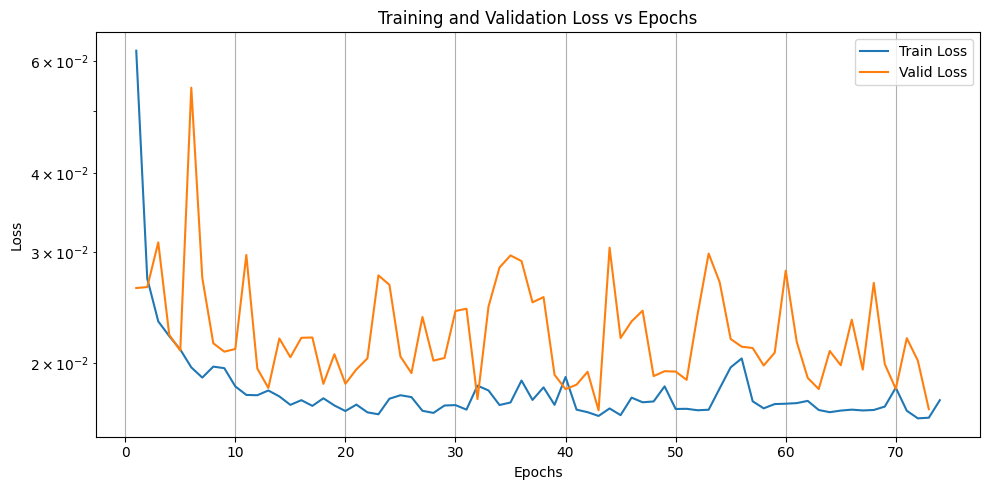

In [76]:
# model = load_model(f"{_exp_name}_best.ckpt")
model, train_losses, valid_losses = try_load_model(_exp_name)
plot_losses(train_losses, valid_losses)

## Evaluation

In [77]:
# Print final statistics
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")
print(f"Best Validation MSE Loss: {min(valid_losses):.5f}")

Total Trainable Parameters: 206052864
Best Validation MSE Loss: 0.01686
